<center><h1>Empik Recruitment Task</h1></center>

<center>
  <h2>Table of contents:</h2>
    <h3>1. Project Overview</h3>
    <h3>2. Evaluation Metrics</h3>
    <h3>3. Used Models</h3>
    <h3>4. Exploratory Data Analysis</h3>
    <h3>5. S-Learner models</h3>
    <h3>6. T-Learner models</h3>
    <h3>7. Summary</h3>
</center>

<center><h2>Project Overview</h2></center>
The goal of this project is to enhance the targeting efficiency of the marketing campaign aimed at persuading customers to subscribe to the term deposit product. We can improve the campaign performance by leveraging <u>Uplift</u> modeling with appropriete machine learning classifiers. We are presented with a dataset consisting of predictors, outcome variable and treatment variable (single - only one way of contact). To properly measure the expected uplift in each model we have to standardize the metrics used for each model as well as introduce a proper validation framework

<center><h2>Evaluation Metrics</h2></center>
As the goal is to identify customers for which the gain from being contacted is the highest, we need to evaulate the model based on metrics which measure not only model performance, but also model performance in identifying those top customers. From the range of uplift metrics I have decided to use three, covering model performance (AUUC score), cumulative gain from targeting the top customers (QINI score) and indicator of model effectiveness in identifying most responsive customers (Uplift at k).

<b>1. AUUC score</b> - Area Under Uplift Curve is a metric used to evaluate the performance of the uplift model. It measures the area under the uplift curve, which plots the incremental gains from targeting customers based on the model's predictions. It starts with ranking all customers by their predicted uplift scores and divides the list into groups (usually deciles). For each group, we calculate the difference in the cumulative response rate between the treatment group and the control group. Lastly we calculate the area under this curve. The higher AUUC indicates better model performance in identifying customers who will respond positively to the intervention, resulting in higher overall incremental gains.

$ \text{AUUC} = \sum_{i=1}^{n} U_i \cdot \Delta x \ $

<b>2. QINI score</b> - A similar metric to the uplift curve but specifically designed for mwasuring the effectiveness of targeted marketing campaigns. It also starts with ranking the best customers, and then it compares the cumulative gain if the same proportion of the population were targeted randomly, with the best possible targeting. The higher QINI score indicates the model is effective at identifyuing customers who will respond positively to the marketing intervention.

$ \text{QINI score} = \sum_{i=1}^{10} (Q_i - R_i) \cdot 0.1 \ $

<b>3. Uplift at k</b> - It is a metric used to evaluate the performance of the model by measuring the incremental response rate among the top K customers ranked by the uplift model. It is particularly useful for assessing how well the model identifies the most responsive individuals within a specific subset of the population. We can measure it either for the entire population as a single group (overall), or within groups, for example within the group of top 30% of customers (by group). It is calculated by segmenting the customers into groups, computing the response rates for both the treated and cobntrol customers and calculating uplift for each group as a difference between the response rates if the treated and control customers. 

$ \text{Uplift@K} = \frac{1}{K} \sum_{i=1}^{K} \left( \text{Response Rate}_{\text{Treated}, i} - \text{Response Rate}_{\text{Control}, i} \right) $

<center><h2>Used Models</h2></center>
To determine which customers are most likely top subscribe to the deposit product I used multiple approaches. The Uplift modeling has its own models, but all of those work based on classical machine learning approaches. In the project I used 3 different Uplift Meta-Learner models: S-Learner, T-Learner (vanila) and T-Learner (ddr control). All of the above models where evaluated using ml classification models: Logistic Regression, XGBoost, CatBoost and SVM with radial kernel.  

<b>S-Learner</b> - It uses a single machine learning model to estimate both the treatment and control effects. The model learns to predict the outcome directly, considering both the features and the treatment indicator

<b>T-Learner</b> - It uses two separate machine learning models, where one is trained and used to predict the treated group and the other is trained and used for control group. The models are trained independently on their respective subsets of the data. In order to estimate the model uplfit, the predictions from the two models are compared for each instance. The difference between the prediction from the treated model and the control model givees the uplfit

*Uplift models and metrics where performed using scikit-uplift (sklift) package, and classifier models are from scikit-learn (sklearn): SVM, LogisticRegression, XGBoost and CatBoost packages.

<center><h2>Exploratory Data Analysis</h2></center>

In [47]:
# for data manipulation polars package is used (later on it will be replaced by pandas as sklift package doesnt support it)
# for ploting seaborn and matplotlib is used
import polars as pl
import polars.selectors as cs
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [39]:
schema = {
    "id": pl.UInt32,
    "age": pl.UInt32,
    "job": pl.String,
    "marital": pl.String,
    "education": pl.String,
    "default": pl.String,
    "housing": pl.String,
    "loan": pl.String,
    "contact": pl.String,
    "month": pl.String,
    "day_of_week": pl.String,
    "duration": pl.UInt32,
    "campaign": pl.UInt32,
    "pdays": pl.UInt32,
    "previous": pl.UInt32,
    "poutcome": pl.String,
    "emp.var.rate": pl.Float32,
    "cons.price.idx": pl.Float32,
    "cons.conf.idx": pl.Float32,
    "euribor3m": pl.Float32,
    "nr.employed": pl.Float32, # start with float, cause one value is float
    "conversion": pl.String, #change y to conversion for better understanding
    "test_control_flag": pl.String
    
}

In [40]:
data = pl.read_csv("data/bank_data_prediction_task_2024.csv", schema=schema, null_values=["NA"])

<h3>change datatypes</h3>

In [41]:
#turn nr.employed to int
data = data.with_columns(pl.col("nr.employed").cast(pl.Int32))

In [42]:
#turn y to 0 and 1
data = data.with_columns(pl.col("conversion").replace({'no': 0, 'yes': 1}).cast(pl.UInt32))

In [43]:
data = data.with_columns(
    pl.col("test_control_flag")
    .replace({'campaign group': 1, 'control group': 0}).cast(pl.UInt32)
    ).rename({"test_control_flag": "in_campaign_group"}
)

In [44]:
data.describe()

statistic,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,conversion,in_campaign_group
str,f64,f64,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",41188.0,41188.0,"""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""16476""","""16476""","""16476""",16476.0,16476.0,41188.0,41188.0,"""41188""",41188.0,40938.0,41188.0,41188.0,41188.0,41188.0,41188.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""24712""","""24712""","""24712""",24712.0,24712.0,0.0,0.0,"""0""",0.0,250.0,0.0,0.0,0.0,0.0,0.0
"""mean""",20594.5,40.02406,null,null,null,null,null,null,null,null,null,259.660172,2.546856,962.475454,0.172963,null,0.081886,93.575951,-40.502602,3.621291,5166.849446,0.125473,0.400019
"""std""",11890.09578,10.42125,null,null,null,null,null,null,null,null,null,260.660561,2.699664,186.910907,0.494901,null,1.57096,0.57889,4.628198,1.734447,72.328375,0.331259,0.489908
"""min""",1.0,17.0,"""admin.""","""divorced""","""basic.4y""","""no""","""no""","""no""","""cellular""","""apr""","""fri""",0.0,1.0,0.0,0.0,"""failure""",-3.4,92.200996,-50.799999,0.634,4963.0,0.0,0.0
"""25%""",10298.0,32.0,null,null,null,null,null,null,null,null,null,103.0,1.0,999.0,0.0,null,-1.8,93.074997,-42.700001,1.344,5099.0,0.0,0.0
"""50%""",20595.0,38.0,null,null,null,null,null,null,null,null,null,180.0,2.0,999.0,0.0,null,1.1,93.749001,-41.799999,4.857,5191.0,0.0,0.0
"""75%""",30891.0,47.0,null,null,null,null,null,null,null,null,null,321.0,3.0,999.0,0.0,null,1.4,93.994003,-36.400002,4.961,5228.0,0.0,1.0
"""max""",41188.0,98.0,"""unknown""","""unknown""","""unknown""","""yes""","""yes""","""yes""","""telephone""","""sep""","""wed""",4918.0,43.0,999.0,7.0,"""success""",1.4,94.766998,-26.9,5.045,5228.0,1.0,1.0


<h3>Missing values</h3>

we have two places of missing values:
1) for control group all of contact, month, day_of_week, campaign, duration are empty
2) for consumer price index there are 250 missing values. 

In [45]:
#we can see that the observations are rather sorted, hence we can fill the null values with forward fill
data = data.with_columns(pl.col("cons.price.idx").forward_fill())

<h3>Data exploration</h3>

### Expectations:
- H1: data is unbalanced - number of not subscribed observations will be much higher
- H2: Mostly elderly people subscribe to the product
- H3: People with loans (housing or loan) or with payment issues (default) are less likely to subscribe
- H4: Social and economic indicators have low impact on the outcome variable

### Dataset balance

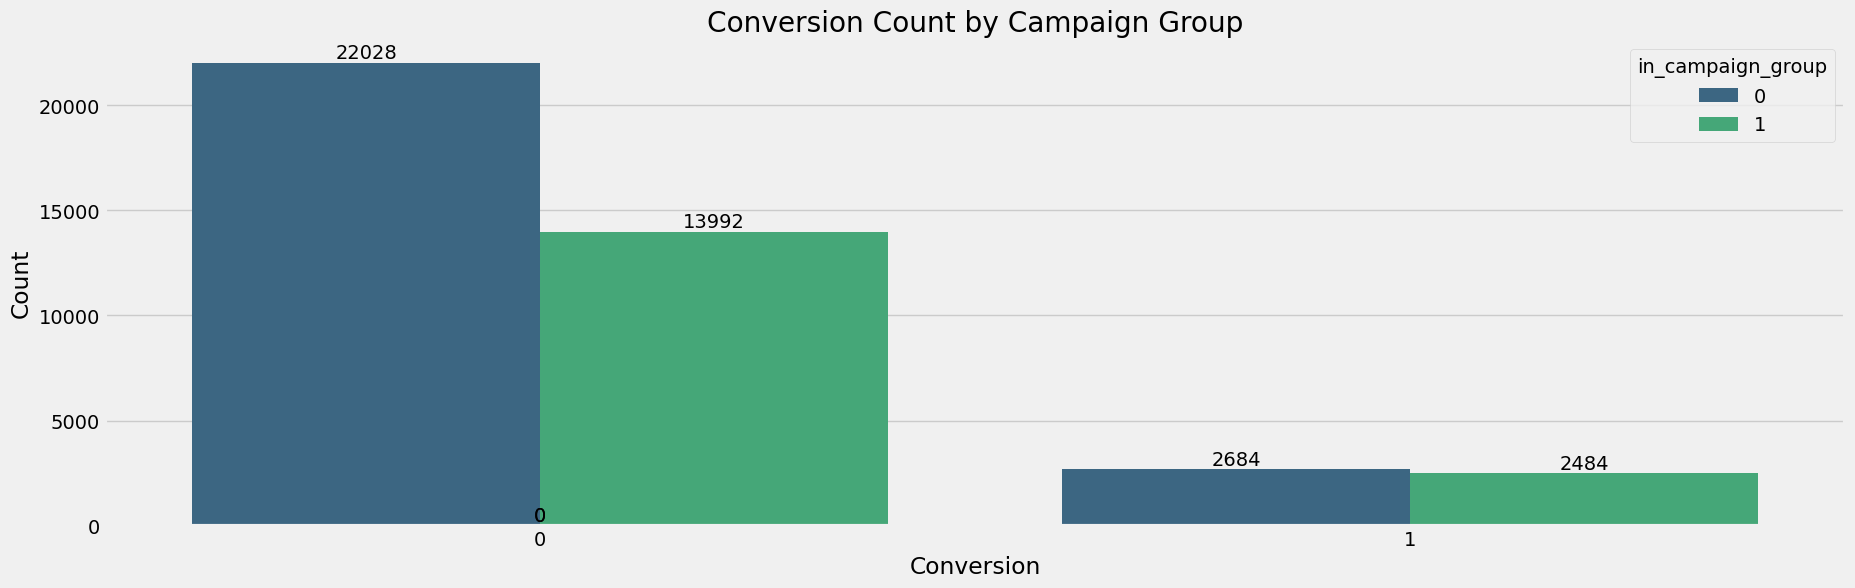

In [46]:
# find balance of the dataset:
counts = data.group_by(["in_campaign_group", "conversion"]).agg(pl.count("conversion").alias("count"))
plt.figure(figsize=(20, 6))
ax = sns.barplot(x="conversion", y="count", hue="in_campaign_group", data=counts, palette="viridis")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, 
            f'{int(height)}', 
            ha="center", va="bottom")

plt.xlabel("Conversion")
plt.ylabel("Count")
plt.title("Conversion Count by Campaign Group")

plt.show()

Only 5168 people subscribed to the product, while over 36 000 did not. It is a clear indicator off unbalanced dataset

the data is heavily unbalanced, indicating that the conversion rate of people who decide to subscribe to product is low.

### Age distribution

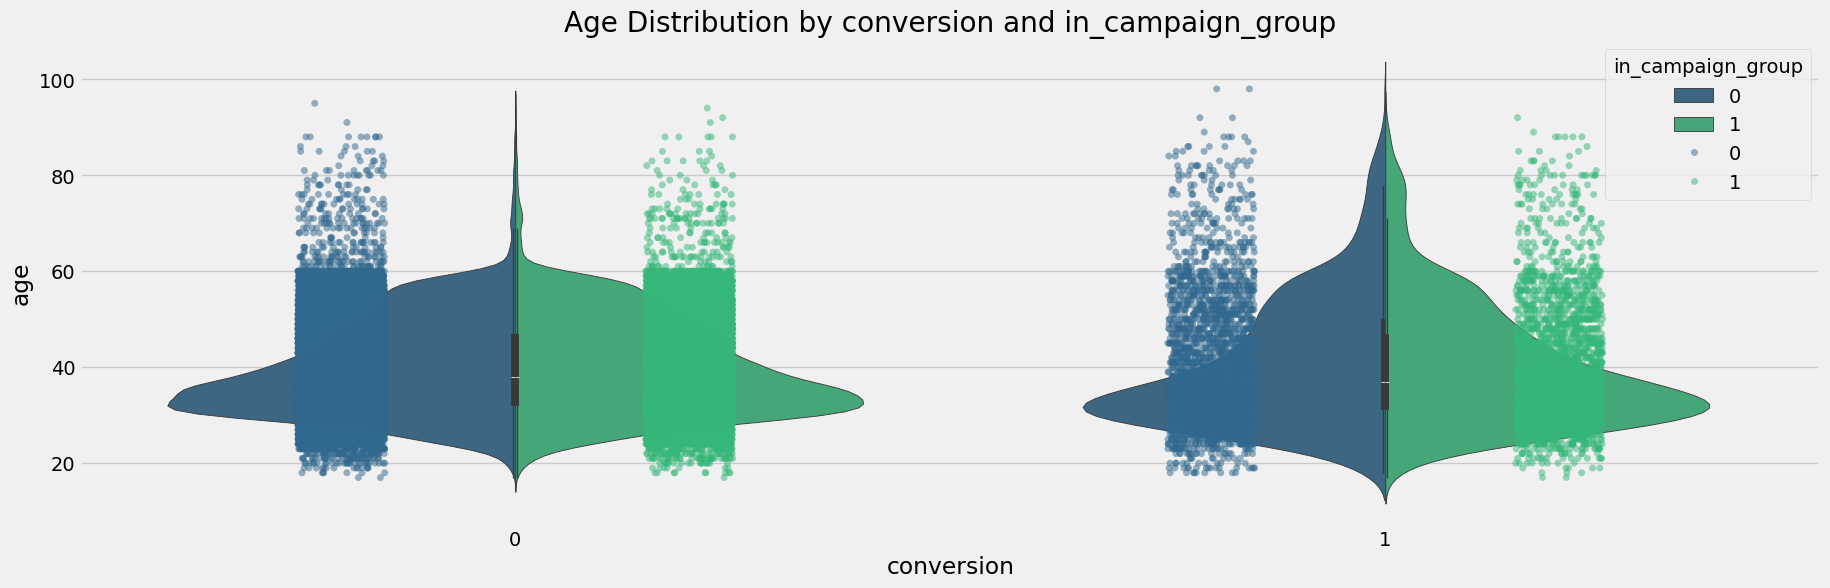

In [51]:
# plot the age distribution for outcome variable (product subscription) distinguishing between the control and campaign group
plt.figure(figsize=(20, 6))
sns.violinplot(data=data, y='age', x='conversion', hue='in_campaign_group', 
               split=True, inner='box', palette="viridis")
sns.stripplot(data=data, y='age', x='conversion', hue='in_campaign_group', 
              dodge=True, jitter=True, palette="viridis", alpha=0.5)
plt.title('Age Distribution by conversion and in_campaign_group')
plt.show()

- We can see that all distribusions for age are higlhy right skewed, indicating that most of observations where conducted on age group under 40 years old. 
- The group who decided to subscribe to product has a thincker tail, but it is not an indicator that edlerly people are more likely to subscribe, as the distributions are simmilar to those who did not decide to subscribe
- the median age for not subscribers is 38 years old, while for subscribers it is 37

### Other categorical variables

In [ ]:
def plot_categorical(data: pl.DataFrame, column: str):
    grouped_data = data.group_by(column, "in_campaign_group", "conversion").agg(
                pl.len().alias("count")
            ).sort(['count'], descending=True)
    
    plt.figure(figsize=(20, 6))
    sns.barplot(data=grouped_data, x=column, y='count', hue='conversion', palette="viridis")
    plt.title(f'Count of {column} by in_campaign_group and conversion')
    plt.show()

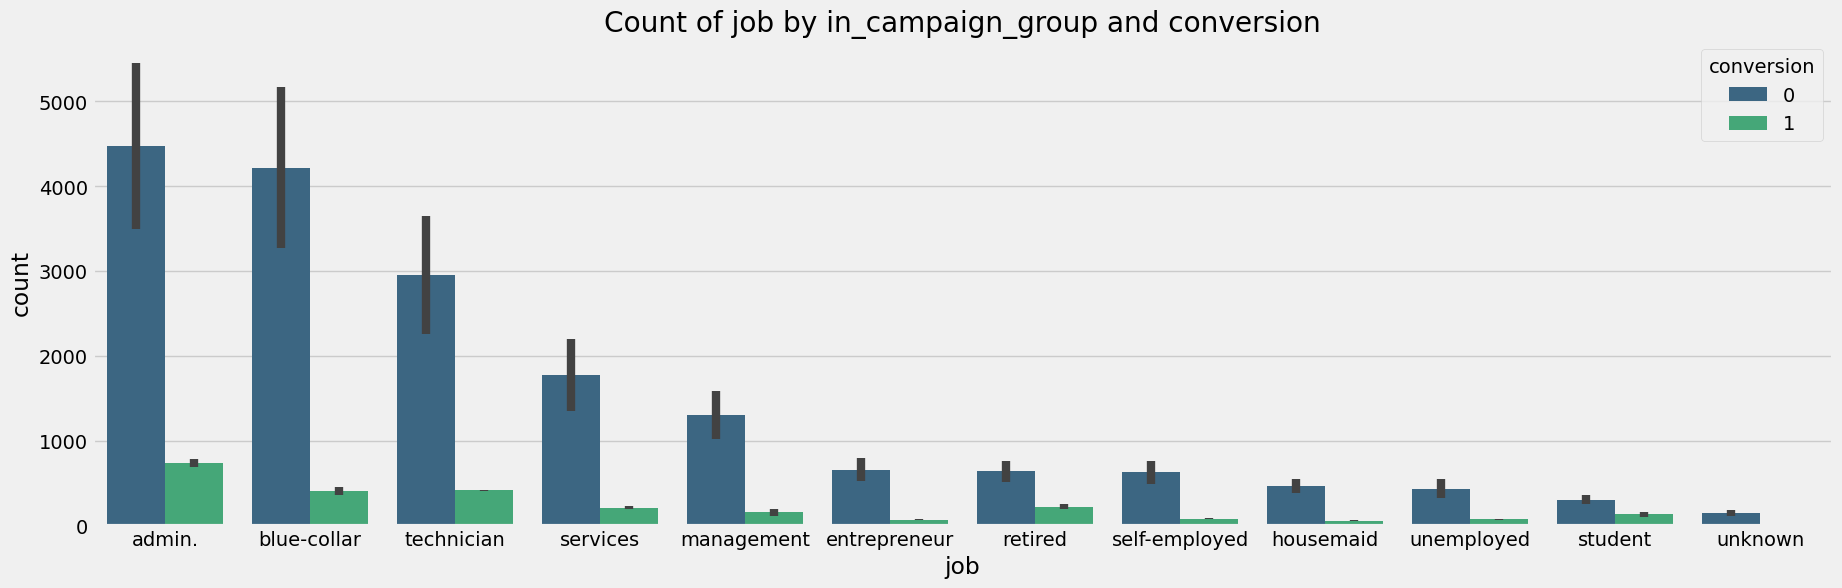

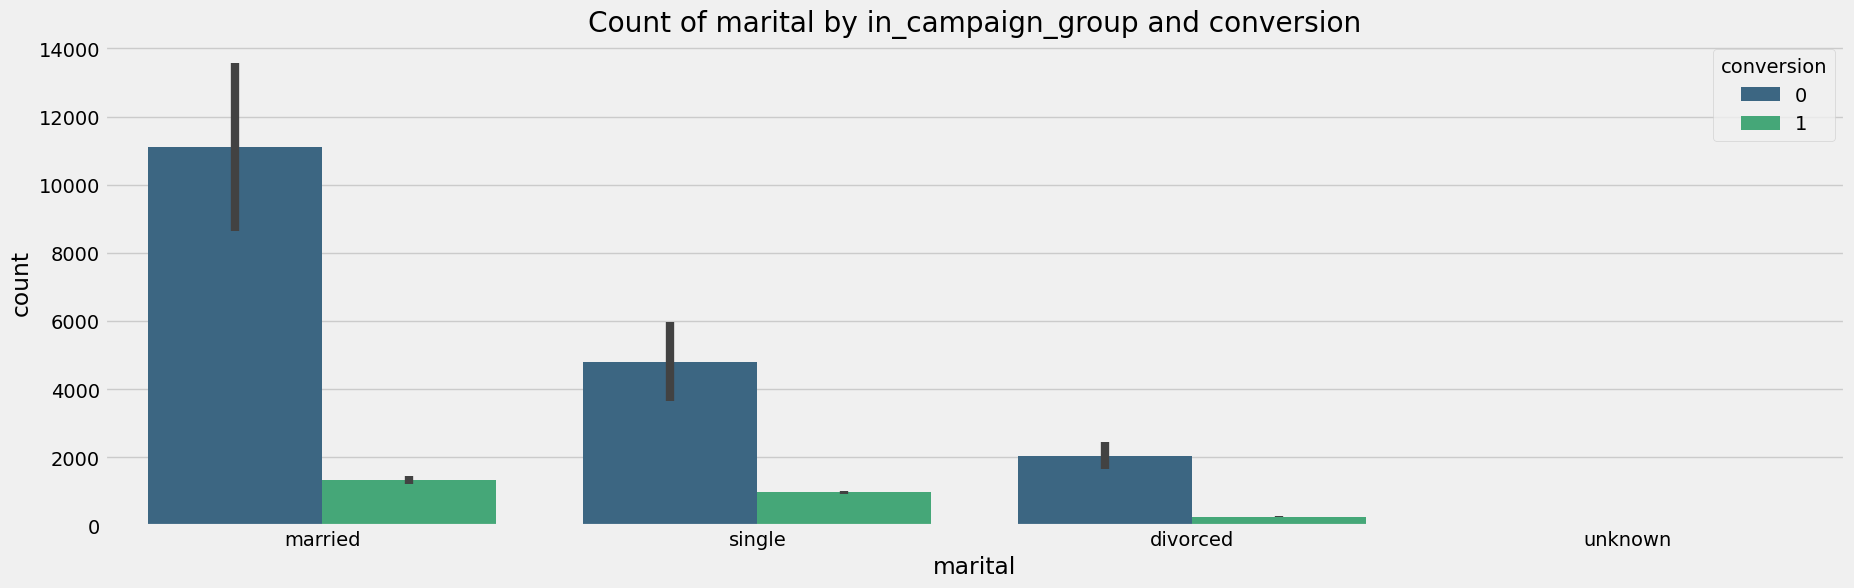

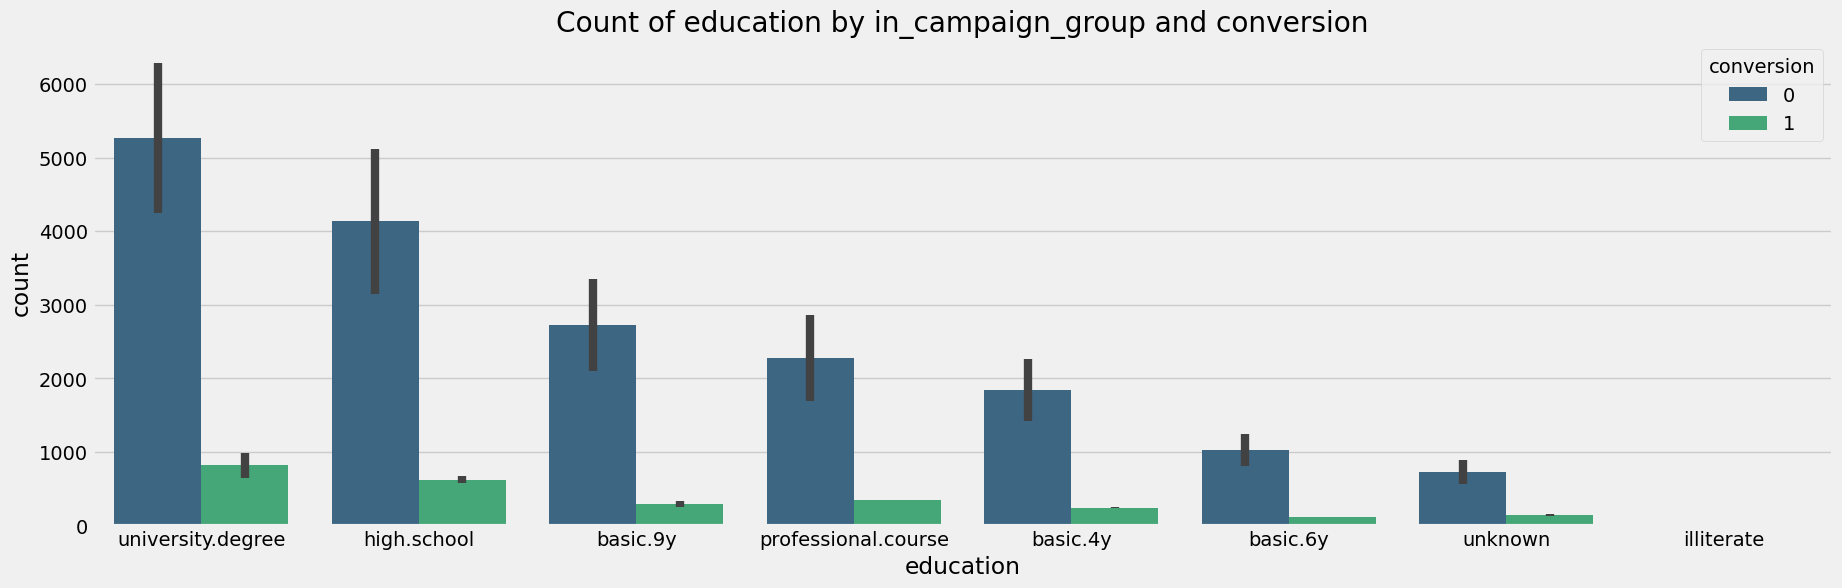

In [68]:
plot_categorical(data, "job")
plot_categorical(data, "marital")
plot_categorical(data, "education")

- the majority of jobs are within admin., blue collar and technician
- the majority of people are married
- the majority of people have university degree or a high school education

- the proportions between those in control and campaign group who chose to subscribe to product is similar for all categories
    - with execptions of blue collar and technician, where more people subscribed when contacted
    - number of retired people who subscribed is proportionaly higher than we would expect if the subscribed part followed the same distribution as not subscribed
    - people with lower education when in campaign group are more likely to subscribe (more contacted people than not contacted between high.school to basic)

### Loans

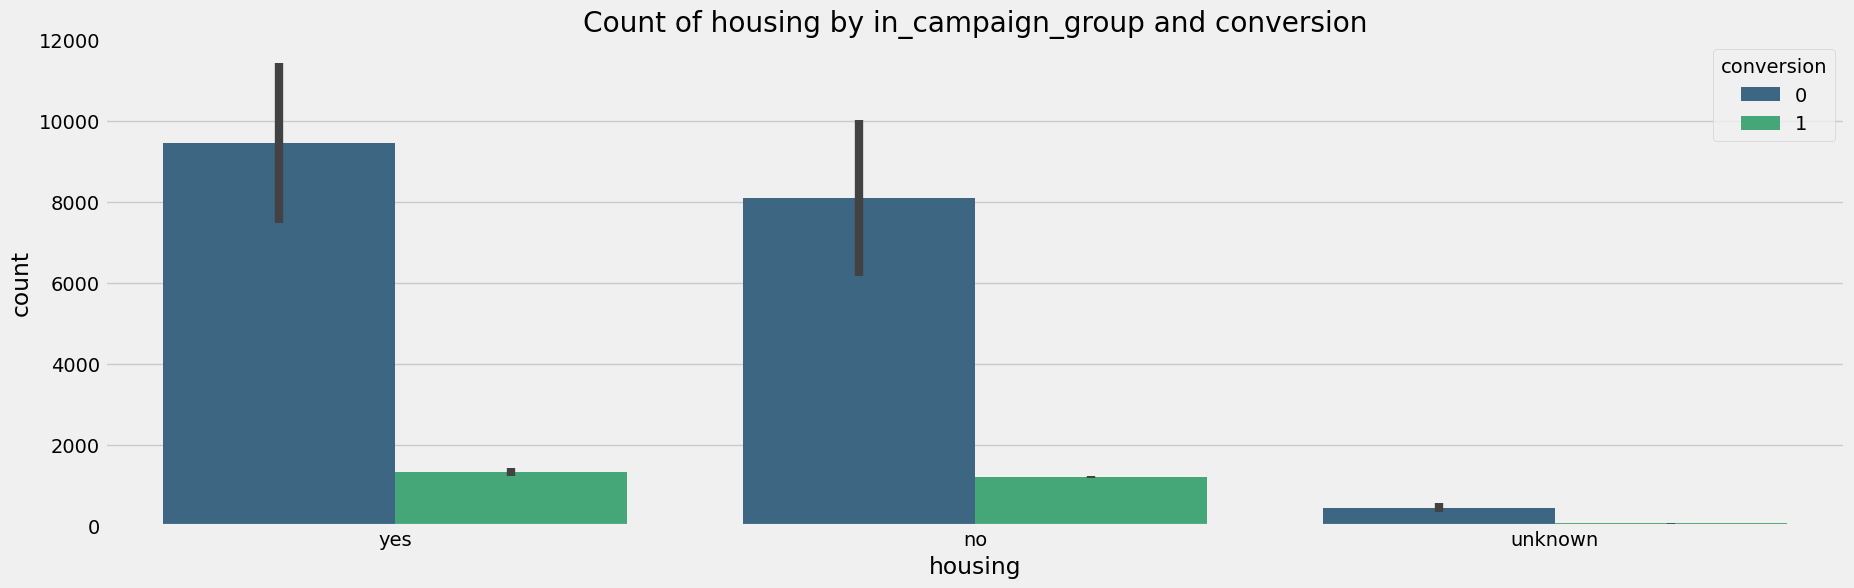

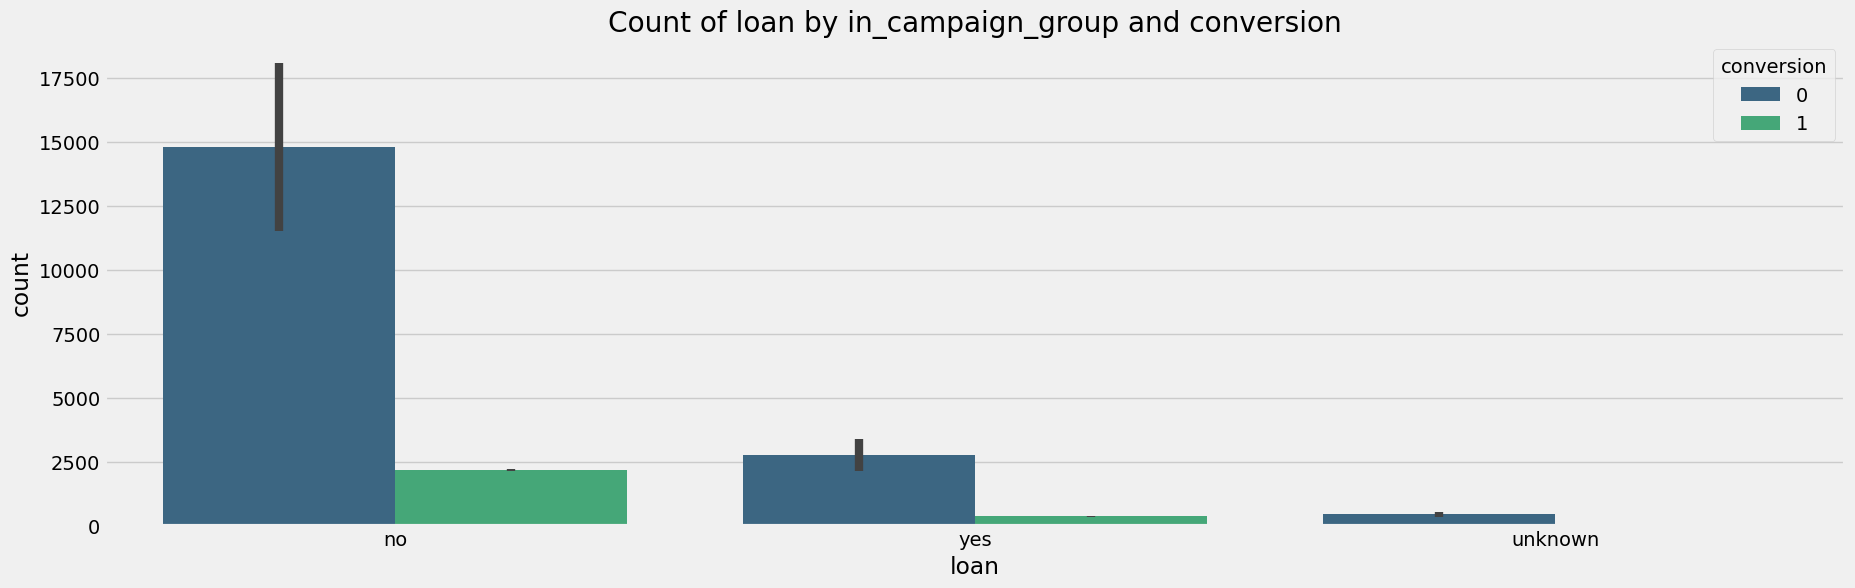

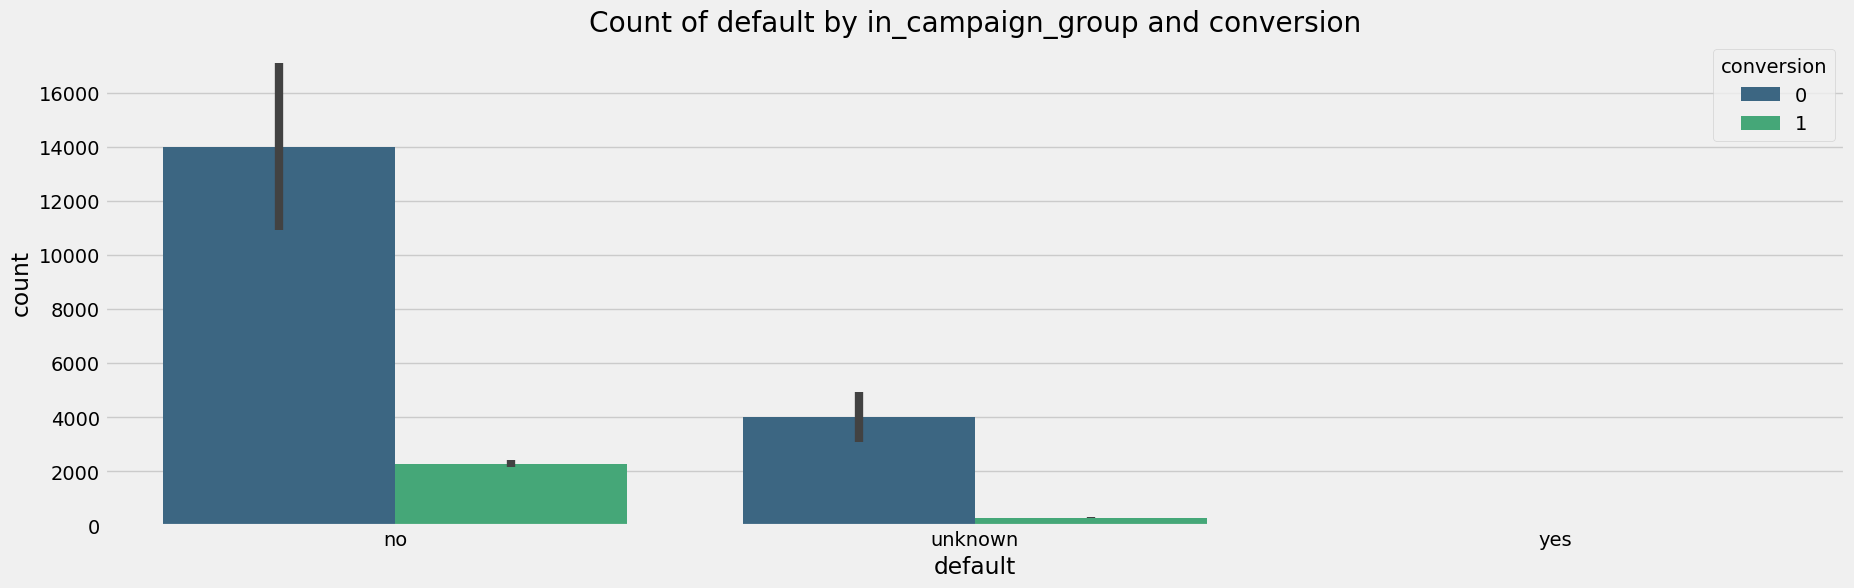

In [69]:
plot_categorical(data, "housing")
plot_categorical(data, "loan")
plot_categorical(data, "default")

- People with housing loans are proportionaly less likely to subscribe
- There is not real difference between subscription and no subscription for people with loans
- Default column bring almost no value as there is only 1 default observation

### Social and economic indicators

calculate point biseral correlation to efffectively measure relation between continous and outcome binary variable

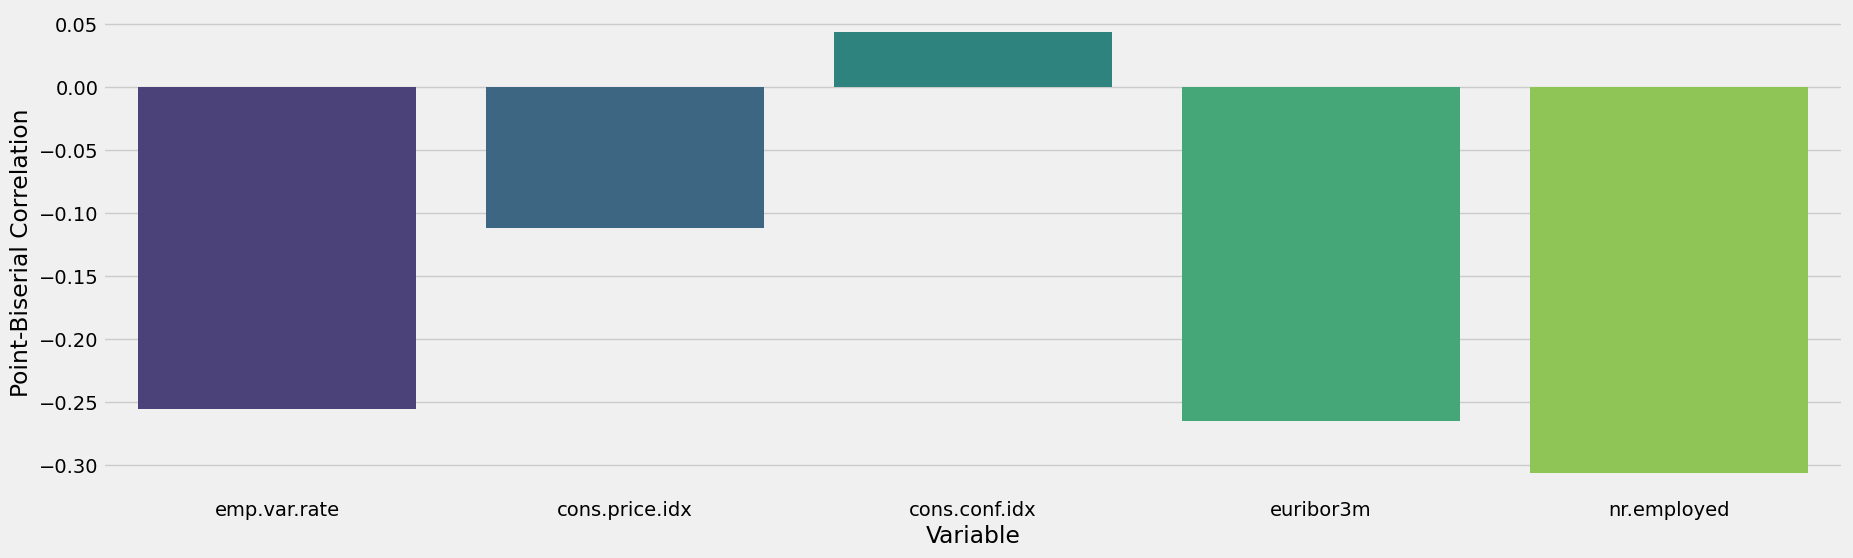

In [70]:
continuous_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
correlations = {}
for var in continuous_vars:
    r_pb, p_value = stats.pointbiserialr(data['conversion'].to_numpy(), data[var].to_numpy())
    correlations[var] = {'Point-Biserial Correlation': r_pb, 'p-value': p_value}

variables = list(correlations.keys())
correlation_values = [correlations[var]['Point-Biserial Correlation'] for var in variables]
p_values = [correlations[var]['p-value'] for var in variables]
corr_df = pl.DataFrame({
    'Variable': variables,
    'Point-Biserial Correlation': correlation_values,
    'p-value': p_values
})

plt.figure(figsize=(20, 6))
sns.barplot(data=corr_df, x='Variable', y='Point-Biserial Correlation', palette="viridis")
plt.show()

- negative `employment variation rate` correlation indicates an inverse relationship between `emp.var.rate` and binary outcome variable `y`
    - the magnitude being 0.25 means a moderate correlation, not very strong but significant
- negative `consumer price index` correlation indicates an inverse relationship between `cons.price.idx` and binary outcome variable `y`
    - the magnitude being 0.11 means a low correlation, but a significant one
- positive `consumer confidence index` correlation indicates a positive relationship between `cons.conf.idx` and binary outcome variable `y`
    - low significant
- negative `euribor 3 month rate` correlation indicates an inverse relationship between `euribor3m` and binary outcome variable `y`
    - the magnitude being 0.26 means a moderate correlation, not very strong but significant
- negative `number of employees` correlation indicates an inverse relationship between `nr.employed` and binary outcome variable `y`
    - the magnitude being 0.3 means a moderate correlation, not very strong but significant

### Contact related features

In [71]:
data_numeric = data.with_columns(pl.col("month")
            .replace({
                "jan": 1,
                "feb": 2,
                "mar": 3,
                "apr": 4,
                "may": 5,
                "jun": 6,
                "jul": 7,
                "aug": 8,
                "sep": 9,
                "oct": 10,
                "nov": 11,
                "dec": 12
            }).cast(pl.UInt32)
        )

data_numeric = data_numeric.with_columns(pl.col("day_of_week")
            .replace({
                "mon": 1,
                "tue": 2,
                "wed": 3,
                "thu": 4,
                "fri": 5
            }).cast(pl.UInt32)
        )

In [ ]:
filtered_data = data_numeric.filter(pl.col("in_campaign_group") == 1)
def plot_contact_categorical(data: pl.DataFrame, column: str):
    grouped_data = data.group_by(column, "conversion").agg(
        pl.len().alias("count")
    ).sort(['count'], descending=True)

    total_counts = grouped_data.group_by(column).agg(
        pl.sum("count")
        .alias("total_count"))
    
    grouped_data = grouped_data.join(total_counts, on=column)
    grouped_data = grouped_data.with_columns(
        (pl.col("count") / pl.col("total_count")).alias("proportion")
    )

    plt.figure(figsize=(20, 6))
    ax = sns.barplot(data=grouped_data, x=column, y='count', hue='conversion', palette="viridis")
    plt.title(f'Proportion of {column} by conversion')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, 
                f'{int(height)}', 
                ha="center", va="bottom")

    plt.show()

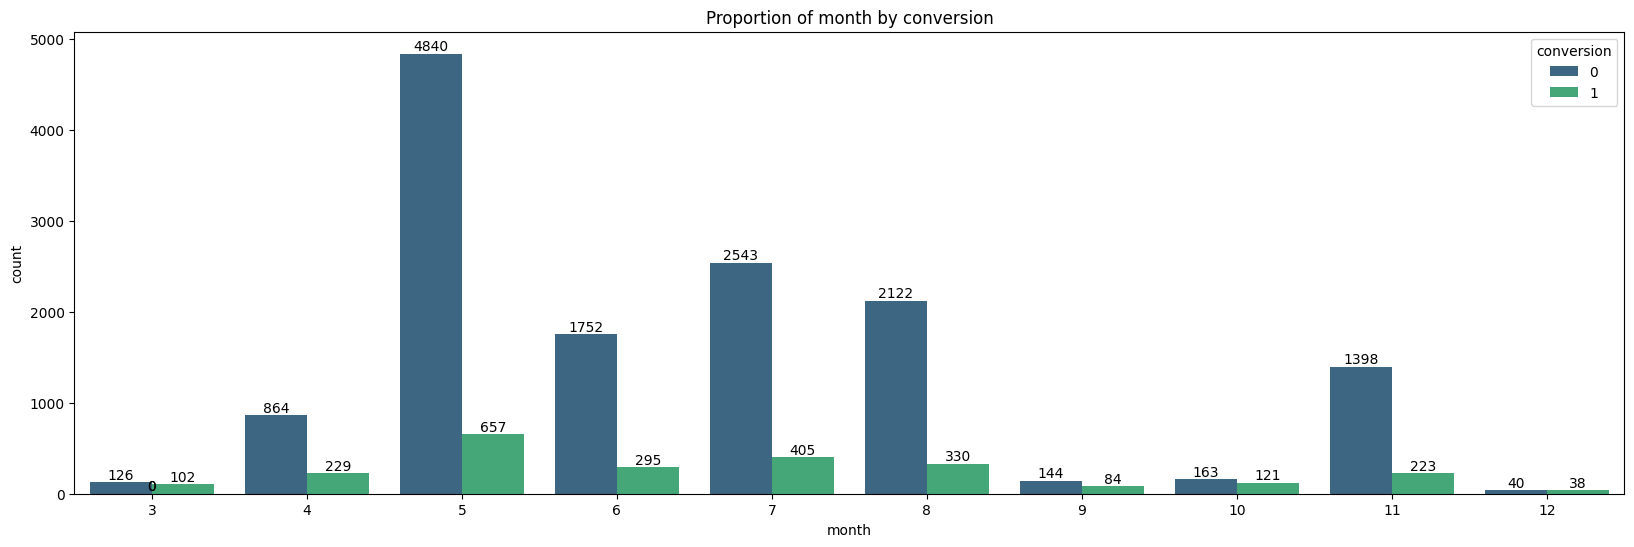

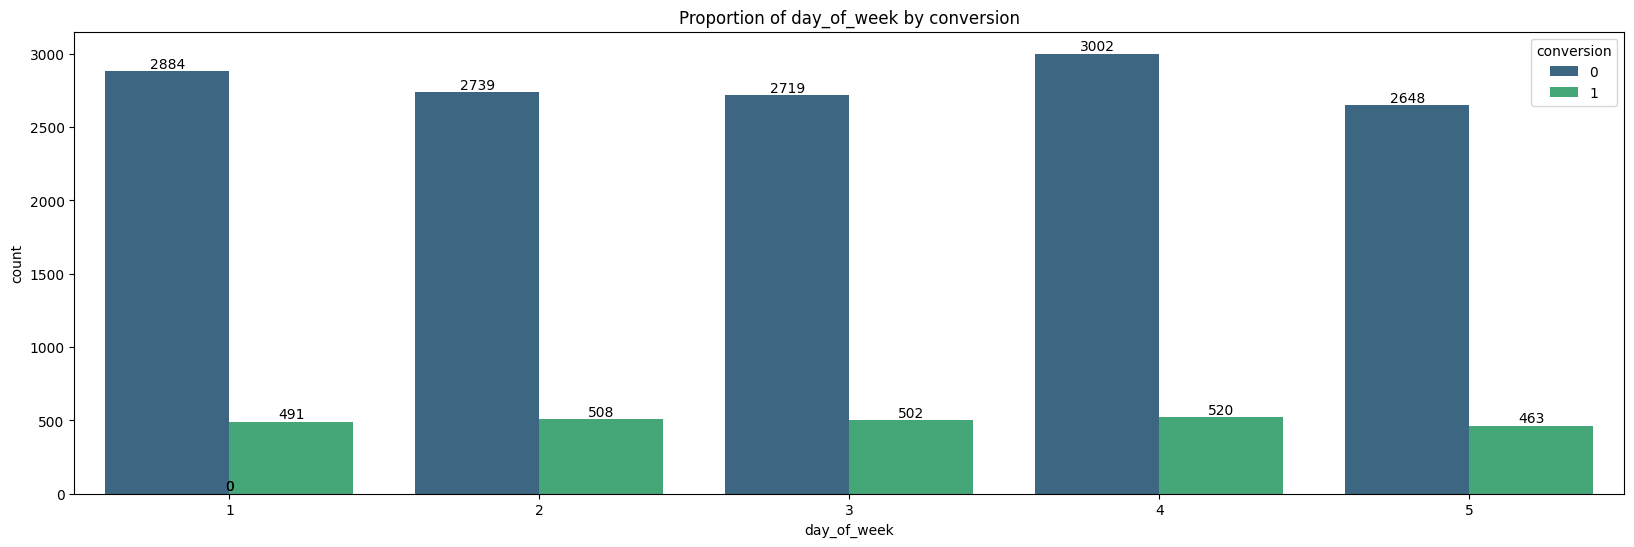

In [17]:
plot_contact_categorical(filtered_data, "contact")
plot_contact_categorical(filtered_data, "month")
plot_contact_categorical(filtered_data, "day_of_week")

- the cellular contact method seem to yield more subscriptions compare to telephone (17% of all cellular contacts resulted in subscription, while only 10% of telephone were succesful)
- there is a huge difference between the observetions within months, as well as the proportions between succesful outcome and total number of contacted people
- day of week proportion doesnt change across the week

the `duration` and `campaign` although may be usefull in predicting subscriptions, we cant assign them in the control group thus we can just drop them. we can also drop the `day_of_week` as it wouldnt bring any value to the model

In [18]:
data = data.drop(["duration", "campaign", "day_of_week"])

In [19]:
# fill missing values in month with "not_contacted"
# fill missing values in contacted with "not_contacted"

data = data.with_columns(
    pl.col("month").fill_null("not_contacted"),
    pl.col("contact").fill_null("not_contacted")
)


In [20]:
data = data.with_columns(
    pl.col("job").cast(pl.Categorical),
    pl.col("marital").cast(pl.Categorical),
    pl.col("education").cast(pl.Categorical),
    pl.col("default").cast(pl.Categorical),
    pl.col("housing").cast(pl.Categorical),
    pl.col("loan").cast(pl.Categorical),
    pl.col("contact").cast(pl.Categorical),
    pl.col("month").cast(pl.Categorical),
    pl.col("poutcome").cast(pl.Categorical),
)

In [21]:
#scale the continous data to range [0, 1]
cols_to_scale = [
    "age", "pdays", "previous", "emp.var.rate", 
    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
]

def min_max_scale(series: pl.Series) -> pl.Series:
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

for col in cols_to_scale:
    data = data.with_columns(min_max_scale(data[col]).alias(col))

In [22]:
data.describe()

statistic,id,age,job,marital,education,default,housing,loan,contact,month,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,conversion,in_campaign_group
str,f64,f64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",41188.0,41188.0,"""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""41188""","""41188""",41188.0,41188.0,"""41188""",41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",20594.5,0.284248,null,null,null,null,null,null,null,null,0.963439,0.024709,null,0.725393,0.535723,0.430853,0.677237,0.769243,0.125473,0.400019
"""std""",11890.09578,0.128657,null,null,null,null,null,null,null,null,0.187098,0.0707,null,0.327283,0.225581,0.193648,0.39321,0.272937,0.331259,0.489908
"""min""",1.0,0.0,null,null,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",10298.0,0.185185,null,null,null,null,null,null,null,null,1.0,0.0,null,0.333333,0.340608,0.338912,0.160961,0.513208,0.0,0.0
"""50%""",20595.0,0.259259,null,null,null,null,null,null,null,null,1.0,0.0,null,0.9375,0.603275,0.376569,0.957379,0.860377,0.0,0.0
"""75%""",30891.0,0.37037,null,null,null,null,null,null,null,null,1.0,0.0,null,1.0,0.698755,0.60251,0.980957,1.0,0.0,1.0
"""max""",41188.0,1.0,null,null,null,null,null,null,null,null,1.0,1.0,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<h1>Uplift modeling</h1>

In [ ]:
from sklearn.model_selection import StratifiedKFold

from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklift.models import SoloModel, TwoModels
from sklift.viz import plot_uplift_curve, plot_qini_curve

import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import numpy as np

<h3>Models definitions</h3>

From my previous machine learning experience the best performing classifier is the Support-Vector-Machine (SVM), but for comparison purposes I used 4 different classifier models

In [24]:
models = {
    'Logit': LogisticRegression(random_state=42, C=0.65, penalty='elasticnet', solver='saga', l1_ratio=0.5),
    'XGB': xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=200, max_depth=7, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, gamma=0.3),
    'CatBoost': cb.CatBoostClassifier(verbose=0, random_state=42, iterations=200, depth=7, learning_rate=0.05, loss_function='Logloss'),
    'SVM': SVC(probability=True, kernel="rbf" ,random_state=42, gamma='auto', C=0.9),
}

<h3>Metrics definitions</h3>

In [25]:
# we have to turn data into pandas dataframe as SoloModel and TwoModels dont support polars dataframes
# turn category to dummies for better model performance
data = data.to_dummies(columns=cs.categorical()).to_pandas()

X = data.drop(["id","conversion", "in_campaign_group"], axis=1)
treatment = data["in_campaign_group"]
y = data["conversion"]

In [ ]:
# create a dataframe to store all models results
results_df = pd.DataFrame()

In [ ]:
# a custom function to get the uplift metrics
# it is a standarized function to get uplift metrics used for all models
# it returns uplift@k (for k between 10% to 50%), uplift@k_all (for k between 10% to 50%), AUUC and qini
# the metric functions are calculated with sklift package
def get_uplift_metrics(y_test, uplift, treatment_test):
    uplift_k_values = {}
    uplift_k_all_values = {}
    
    for k in [0.1, 0.2, 0.3, 0.4, 0.5]:
        uplift_k = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='by_group', k=k)
        uplift_k_all = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treatment_test, strategy='overall', k=k)
        
        uplift_k_values[f'uplift@{int(k*100)}'] = uplift_k
        uplift_k_all_values[f'uplift@{int(k*100)}_all'] = uplift_k_all
        
        print(f'uplift at top {int(k*100)}% by group: {uplift_k:.3f}, and overall {uplift_k_all:.3f}')
    
    uplift_auc = uplift_auc_score(y_true=y_test, uplift=uplift, treatment=treatment_test)
    uplift_qini = qini_auc_score(y_true=y_test, uplift=uplift, treatment=treatment_test)
    
    print(f'AUUC: {uplift_auc:.3f}')
    print(f'qini: {uplift_qini:.3f}')
    print("------------------------------------------------")
    
    return {**uplift_k_values, **uplift_k_all_values, 'AUUC': uplift_auc, 'qini': uplift_qini}



In [ ]:
# a custom function to plot the uplift curve and qini curve
# it is a standarized function to plot the uplift curve and qini curve for all models
# it uses sklift package to plot the curves
def plot_uplift_results(y_test, uplift_sm, treatment_test, model_name, ax1, ax2, i):
    # Plot Uplift Curve
    uplift_disp = plot_uplift_curve(
        y_test, uplift_sm, treatment_test,
        perfect=True, random=True, ax=ax1
    )
    ax1.set_title(f"cv fold.{i}, {model_name} Uplift curve", fontsize=10)
    ax1.set_xlabel("Proportion Targeted", fontsize=8, color='black')
    ax1.set_ylabel("Uplift", fontsize=8, color='black')
    ax1.tick_params(axis='both', which='major', labelsize=6)

    # Plot Qini Curve
    qini_disp = plot_qini_curve(
        y_test, uplift_sm, treatment_test,
        perfect=True, random=True, ax=ax2
    )
    ax2.set_title(f"cv fold.{i}, {model_name} Qini curve", fontsize=10)
    ax2.set_xlabel("Proportion Targeted", fontsize=8, color='black')
    ax2.set_ylabel("Qini", fontsize=8, color='black')
    ax2.tick_params(axis='both', which='major', labelsize=6)

<h2>S-Learner model</h2>

to properly measure each model and classifier performance I created custom cross validation functions, and evaluated the model with 50 folds. Cross validation helps assesing the model performance multiple time on the data not seen before. It divides the data into bins: test and train, calcualtes the statistics with functions defined earlier. Then it startes again, by taking another bin as a validation set and training model with the remaining bins. In the codes there are 2 simmilar functions for S-Learner and T-Learner, as the models use different parameters in model.fit. Each cross validation iteration prints its results with the get_uplift_metrics function, and after all folds it plots the average results. By uncommenting codes in cross validation function we can also plot the uplift in each fold

In [29]:
def cross_validate_uplift_slearner(model, X, y, treatment, model_name, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {
        'uplift@10': [], 'uplift@20': [], 'uplift@30': [], 'uplift@40': [], 'uplift@50': [],
        'uplift@10_all': [], 'uplift@20_all': [], 'uplift@30_all': [], 'uplift@40_all': [], 'uplift@50_all': [],
        'AUUC': [], 'qini': []
    }

    y_tests = []
    uplifts = []
    treatment_tests = []

    # fig, axes = plt.subplots(nrows=cv, ncols=2, figsize=(20, 3*cv))
    # axes = np.atleast_2d(axes)

    for i, (train_idx, test_idx) in enumerate(skf.split(X, treatment)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
        
        model.fit(X=X_train, y=y_train, treatment=treatment_train, estimator_fit_params={})
        uplift = model.predict(X_test)

        y_tests.append(y_test)
        uplifts.append(uplift)
        treatment_tests.append(treatment_test)
        
        fold_metrics = get_uplift_metrics(y_test, uplift, treatment_test)
        # plot_uplift_results(y_test, uplift, treatment_test=treatment_test, model_name=model_name, ax1=axes[i, 0], ax2=axes[i, 1], i=i)
        
        for k in [10, 20, 30, 40, 50]:
            metrics[f'uplift@{k}'].append(fold_metrics[f'uplift@{k}'])
            metrics[f'uplift@{k}_all'].append(fold_metrics[f'uplift@{k}_all'])
        
        metrics['AUUC'].append(fold_metrics['AUUC'])
        metrics['qini'].append(fold_metrics['qini'])
    
    y_test_all = pd.concat(y_tests)
    uplift_all = np.concatenate(uplifts)
    treatment_test_all = pd.concat(treatment_tests)

    fig_mean, axes_mean = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    plot_uplift_results(y_test_all, uplift_all, treatment_test_all, model_name, ax1=axes_mean[0], ax2=axes_mean[1], i='mean')

    plt.tight_layout()
    plt.show()
    
    mean_metrics = {key: np.mean(value) for key, value in metrics.items()}
    std_metrics = {key: np.std(value) for key, value in metrics.items()}
    
    return mean_metrics, std_metrics

In [30]:
def run_slearner_models_and_get_metrics(models, X, y, treatment, cv=10):
    results = []
    
    for model_name, model in models.items():
        sm = SoloModel(estimator=model)

        print("\n")
        print("\n")
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_slearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated S-Learner {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "s_learner_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df





--------------------------------------------------------------------
Running model: Logit
uplift at top 10% by group: -0.126, and overall -0.063
uplift at top 20% by group: 0.073, and overall -0.008
uplift at top 30% by group: 0.104, and overall 0.006
uplift at top 40% by group: 0.088, and overall 0.025
uplift at top 50% by group: 0.089, and overall 0.020
AUUC: -0.061
qini: 2.936
------------------------------------------------
uplift at top 10% by group: -0.045, and overall -0.056
uplift at top 20% by group: -0.003, and overall -0.059
uplift at top 30% by group: 0.030, and overall 0.024
uplift at top 40% by group: 0.052, and overall 0.012
uplift at top 50% by group: 0.048, and overall 0.014
AUUC: -0.053
qini: 4.677
------------------------------------------------
uplift at top 10% by group: -0.167, and overall -0.127
uplift at top 20% by group: -0.059, and overall -0.084
uplift at top 30% by group: -0.031, and overall -0.097
uplift at top 40% by group: -0.011, and overall -0.083
u

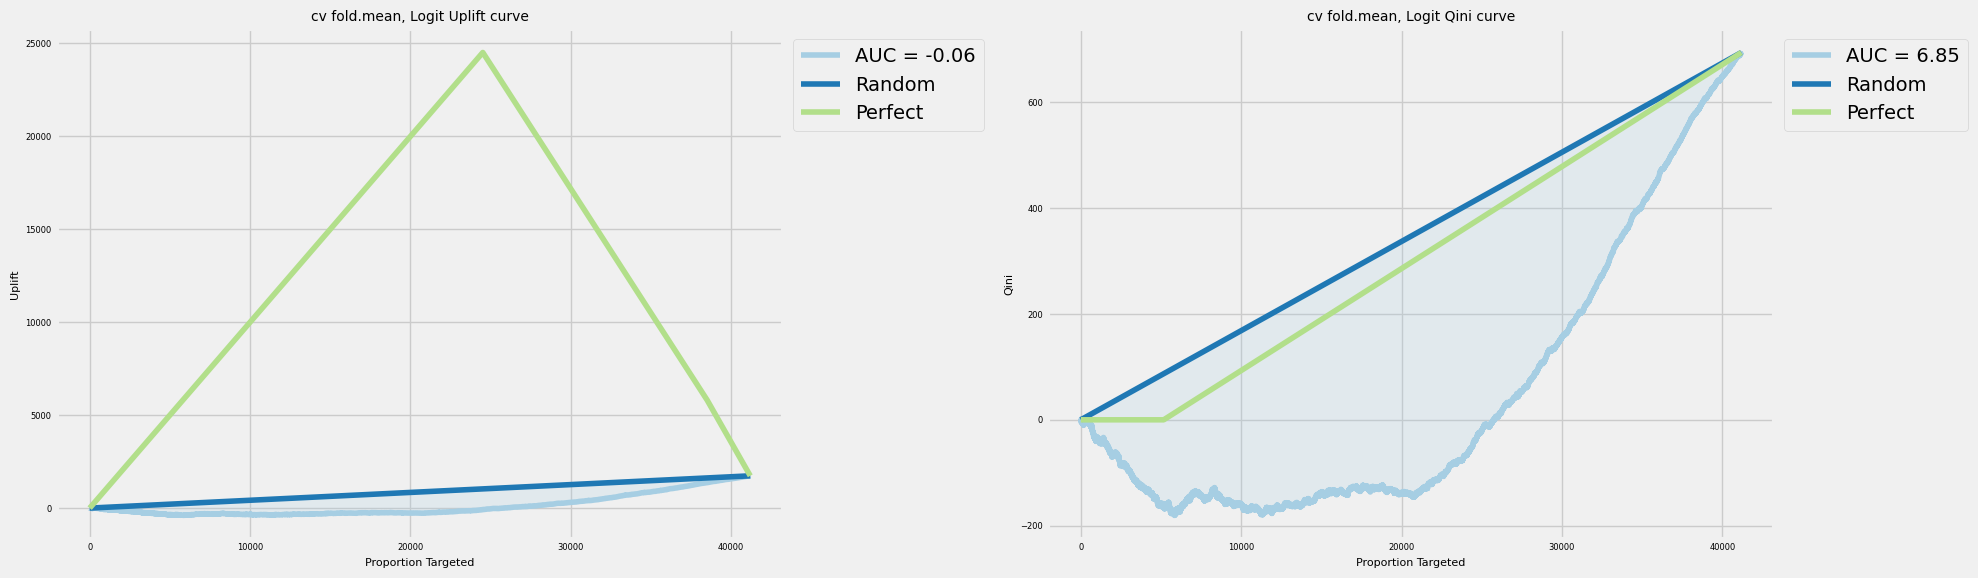

--------------------------------------------------------------------
Cross-validated S-Learner Logit Uplift Metrics (Mean):
uplift@10: -0.053
uplift@20: 0.003
uplift@30: 0.026
uplift@40: 0.042
uplift@50: 0.053
uplift@10_all: -0.073
uplift@20_all: -0.040
uplift@30_all: -0.030
uplift@40_all: -0.014
uplift@50_all: -0.011
AUUC: -0.063
qini: 8.816




--------------------------------------------------------------------
Running model: XGB
uplift at top 10% by group: -0.022, and overall -0.089
uplift at top 20% by group: 0.059, and overall -0.046
uplift at top 30% by group: 0.030, and overall 0.020
uplift at top 40% by group: 0.063, and overall 0.037
uplift at top 50% by group: 0.064, and overall 0.068
AUUC: -0.030
qini: 2.155
------------------------------------------------
uplift at top 10% by group: 0.130, and overall 0.039
uplift at top 20% by group: 0.024, and overall 0.075
uplift at top 30% by group: 0.050, and overall 0.032
uplift at top 40% by group: 0.078, and overall 0.081
uplift at

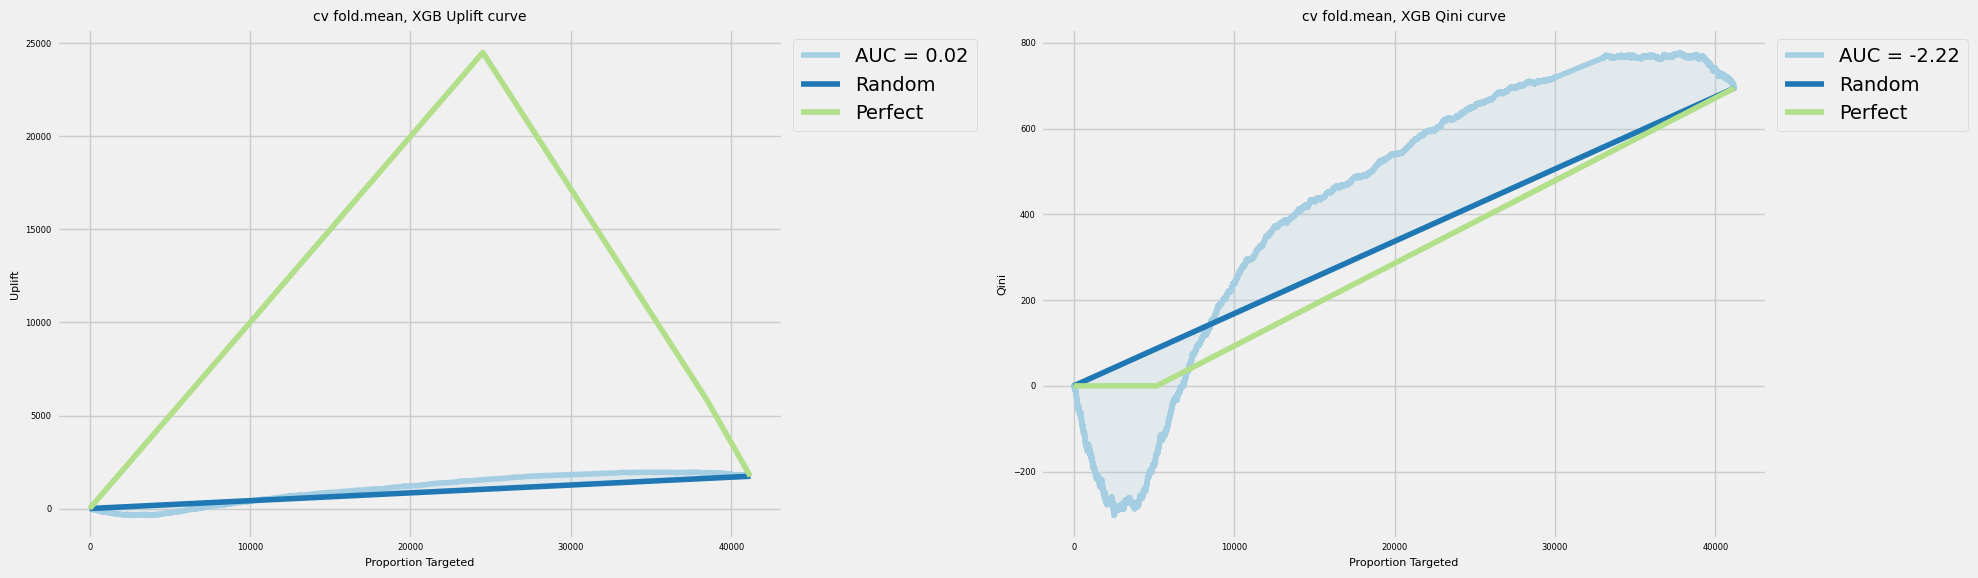

--------------------------------------------------------------------
Cross-validated S-Learner XGB Uplift Metrics (Mean):
uplift@10: 0.046
uplift@20: 0.064
uplift@30: 0.069
uplift@40: 0.069
uplift@50: 0.067
uplift@10_all: -0.060
uplift@20_all: 0.019
uplift@30_all: 0.047
uplift@40_all: 0.059
uplift@50_all: 0.061
AUUC: 0.017
qini: -1.496




--------------------------------------------------------------------
Running model: CatBoost
uplift at top 10% by group: 0.171, and overall 0.077
uplift at top 20% by group: 0.161, and overall 0.113
uplift at top 30% by group: 0.118, and overall 0.120
uplift at top 40% by group: 0.101, and overall 0.143
uplift at top 50% by group: 0.133, and overall 0.119
AUUC: 0.047
qini: -3.814
------------------------------------------------
uplift at top 10% by group: 0.151, and overall 0.045
uplift at top 20% by group: 0.059, and overall 0.065
uplift at top 30% by group: 0.084, and overall 0.066
uplift at top 40% by group: 0.078, and overall 0.081
uplift at top 

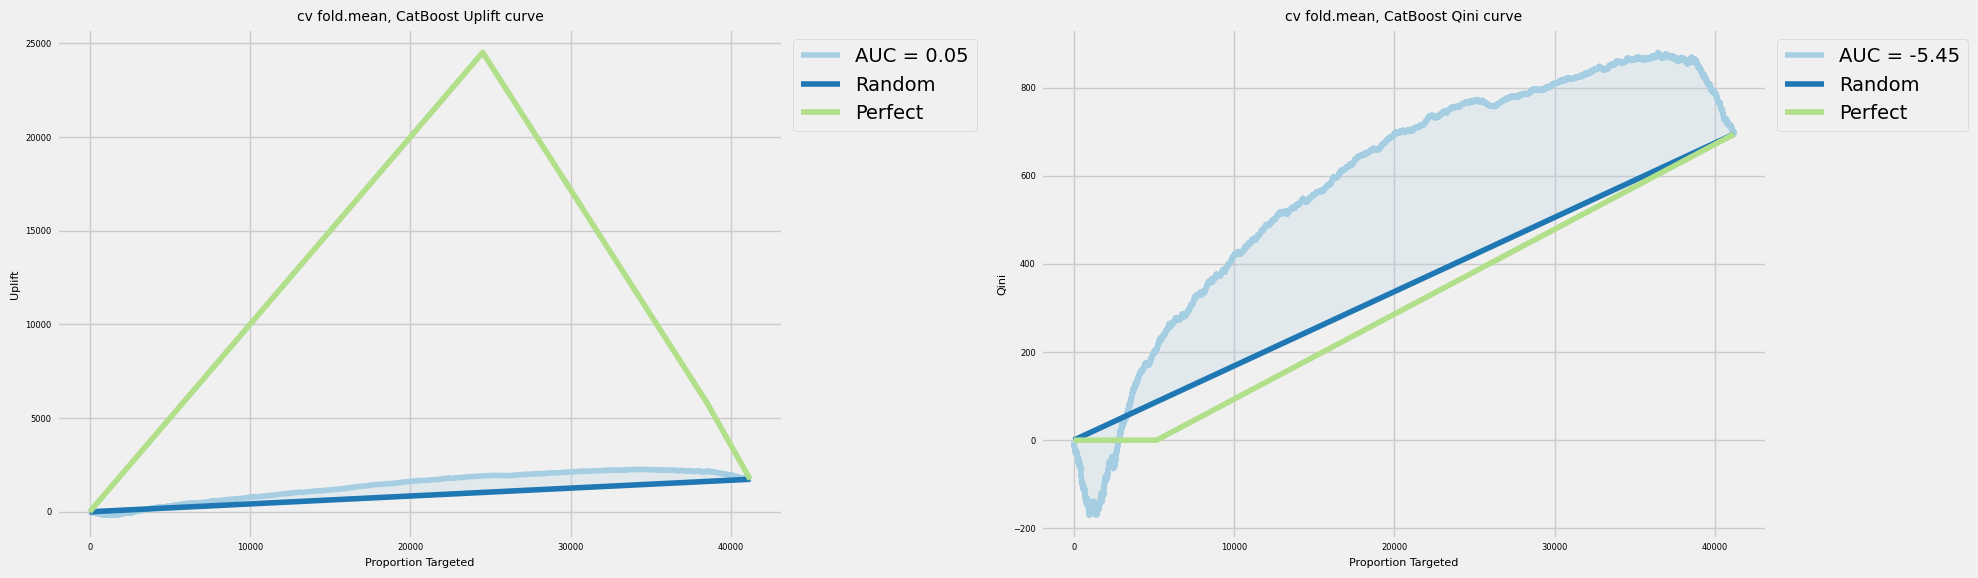

--------------------------------------------------------------------
Cross-validated S-Learner CatBoost Uplift Metrics (Mean):
uplift@10: 0.089
uplift@20: 0.105
uplift@30: 0.094
uplift@40: 0.089
uplift@50: 0.087
uplift@10_all: 0.043
uplift@20_all: 0.079
uplift@30_all: 0.078
uplift@40_all: 0.082
uplift@50_all: 0.082
AUUC: 0.046
qini: -6.207




--------------------------------------------------------------------
Running model: SVM
uplift at top 10% by group: -0.004, and overall 0.086
uplift at top 20% by group: 0.033, and overall 0.149
uplift at top 30% by group: 0.026, and overall 0.059
uplift at top 40% by group: 0.012, and overall 0.031
uplift at top 50% by group: 0.018, and overall 0.037
AUUC: -0.035
qini: 2.710
------------------------------------------------
uplift at top 10% by group: 0.048, and overall 0.257
uplift at top 20% by group: 0.079, and overall 0.125
uplift at top 30% by group: 0.080, and overall 0.120
uplift at top 40% by group: 0.095, and overall 0.102
uplift at top 

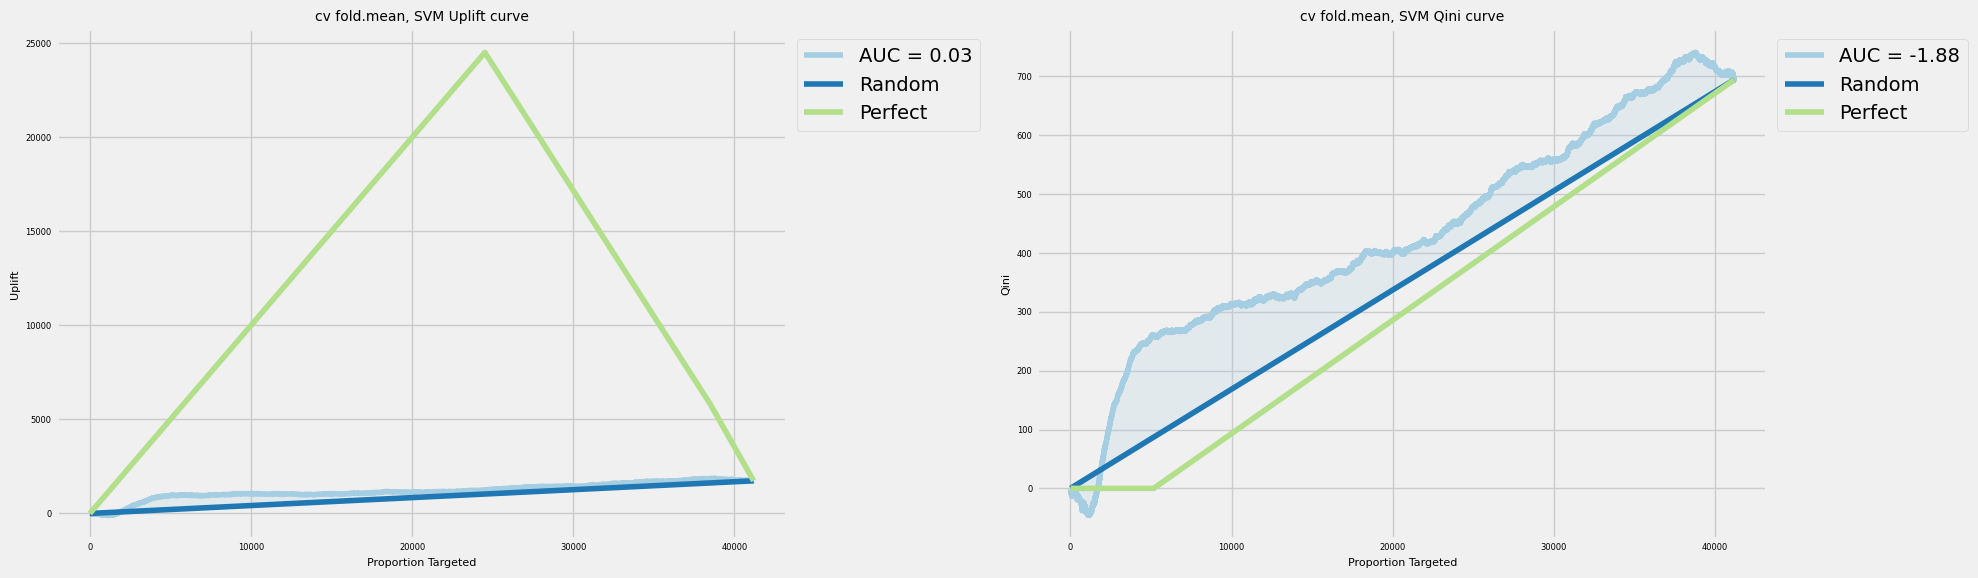

--------------------------------------------------------------------
Cross-validated S-Learner SVM Uplift Metrics (Mean):
uplift@10: 0.071
uplift@20: 0.056
uplift@30: 0.055
uplift@40: 0.053
uplift@50: 0.050
uplift@10_all: 0.209
uplift@20_all: 0.121
uplift@30_all: 0.087
uplift@40_all: 0.064
uplift@50_all: 0.057
AUUC: 0.028
qini: -2.163


In [31]:
results_s = run_slearner_models_and_get_metrics(models, X, y, treatment, cv=50)
results_df = pd.concat([results_df, results_s])

The S-Learner is not an efficient model. There is no one model for which all the valuated metrics would be satisfactory

<h2>T-Learner - vanila</h2>

The vanila model fits separate models for the treatment and control groups and then estimates treatment effects by comparing predicted outcomes.

In [32]:
def cross_validate_uplift_tlearner(model, X, y, treatment, model_name, cv=5): #different models have different parameters in fit function
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {
        'uplift@10': [], 'uplift@20': [], 'uplift@30': [], 'uplift@40': [], 'uplift@50': [],
        'uplift@10_all': [], 'uplift@20_all': [], 'uplift@30_all': [], 'uplift@40_all': [], 'uplift@50_all': [],
        'AUUC': [], 'qini': []
    }

    y_tests = []
    uplifts = []
    treatment_tests = []

    # fig, axes = plt.subplots(nrows=cv, ncols=2, figsize=(14, 3*cv))
    # axes = np.atleast_2d(axes)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, treatment)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
        
        model.fit(X=X_train, y=y_train, treatment=treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={}) #only the fit parameter names change
        uplift = model.predict(X_test)

        y_tests.append(y_test)
        uplifts.append(uplift)
        treatment_tests.append(treatment_test)
        
        fold_metrics = get_uplift_metrics(y_test, uplift, treatment_test)
        # plot_uplift_results(y_test, uplift, treatment_test=treatment_test, model_name=model_name, ax1=axes[i, 0], ax2=axes[i, 1], i=i)
        
        for k in [10, 20, 30, 40, 50]:
            metrics[f'uplift@{k}'].append(fold_metrics[f'uplift@{k}'])
            metrics[f'uplift@{k}_all'].append(fold_metrics[f'uplift@{k}_all'])
        
        metrics['AUUC'].append(fold_metrics['AUUC'])
        metrics['qini'].append(fold_metrics['qini'])

    y_test_all = pd.concat(y_tests)
    uplift_all = np.concatenate(uplifts)
    treatment_test_all = pd.concat(treatment_tests)

    fig_mean, axes_mean = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    plot_uplift_results(y_test_all, uplift_all, treatment_test_all, model_name, ax1=axes_mean[0], ax2=axes_mean[1], i='mean')

    plt.tight_layout()
    plt.show()
    
    mean_metrics = {key: np.mean(value) for key, value in metrics.items()}
    std_metrics = {key: np.std(value) for key, value in metrics.items()}
    
    return mean_metrics, std_metrics

In [33]:
def run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=50):
    results = []
    
    for model_name, model in models.items():
        treatment_model = type(model)(**model.get_params()) #create separate instances of the same model
        control_model = type(model)(**model.get_params())
        sm = TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model)
        print("\n")
        print("\n")
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_tlearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated T-Learner Vanila {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "t_learner_vanila_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df





--------------------------------------------------------------------
Running model: Logit
uplift at top 10% by group: 0.262, and overall 0.251
uplift at top 20% by group: 0.176, and overall 0.191
uplift at top 30% by group: 0.134, and overall 0.142
uplift at top 40% by group: 0.118, and overall 0.128
uplift at top 50% by group: 0.105, and overall 0.116
AUUC: 0.051
qini: -2.745
------------------------------------------------
uplift at top 10% by group: 0.191, and overall 0.222
uplift at top 20% by group: 0.146, and overall 0.141
uplift at top 30% by group: 0.131, and overall 0.138
uplift at top 40% by group: 0.098, and overall 0.094
uplift at top 50% by group: 0.117, and overall 0.118
AUUC: 0.080
qini: -7.811
------------------------------------------------
uplift at top 10% by group: 0.160, and overall 0.153
uplift at top 20% by group: 0.140, and overall 0.127
uplift at top 30% by group: 0.084, and overall 0.098
uplift at top 40% by group: 0.073, and overall 0.065
uplift at top 50

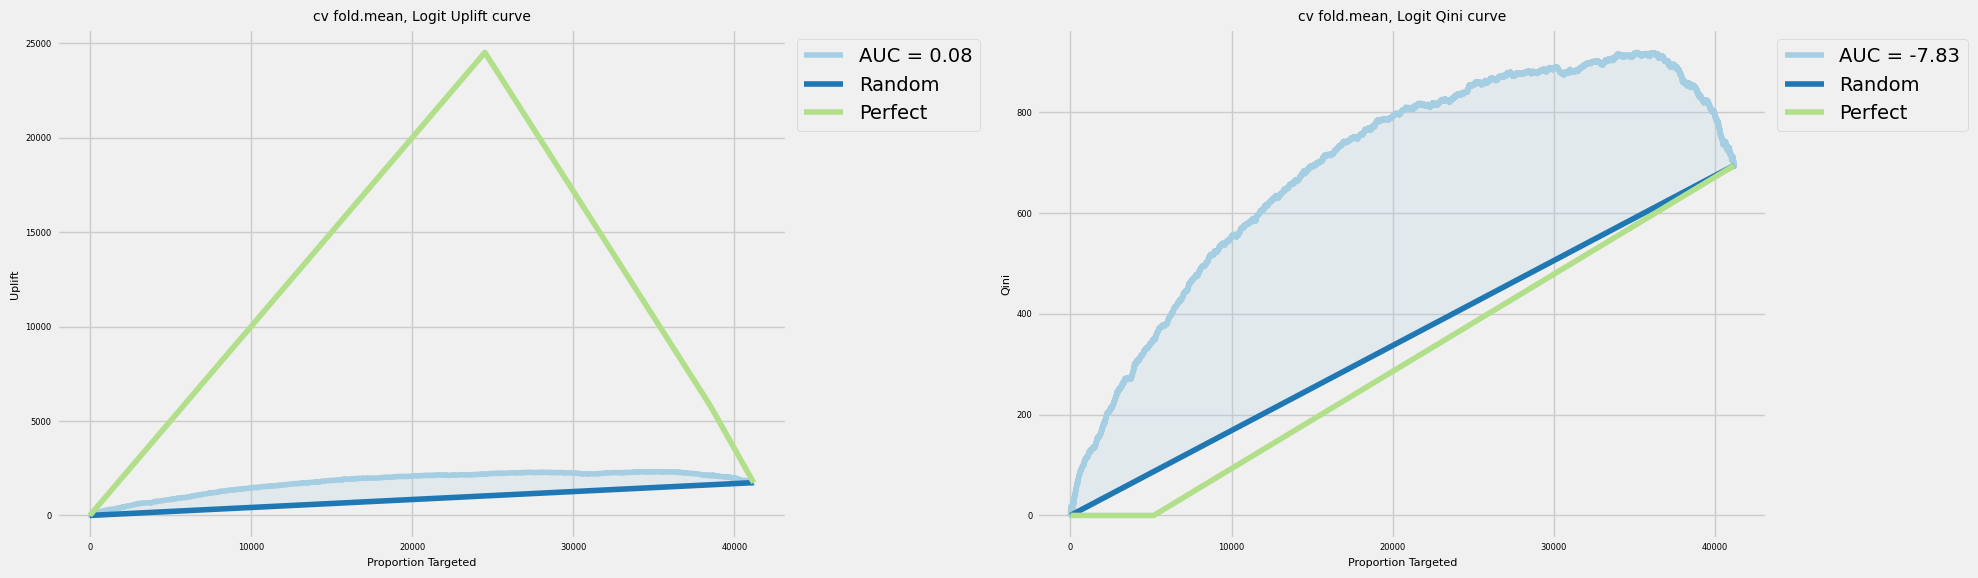

--------------------------------------------------------------------
Cross-validated T-Learner Vanila Logit Uplift Metrics (Mean):
uplift@10: 0.181
uplift@20: 0.151
uplift@30: 0.129
uplift@40: 0.113
uplift@50: 0.099
uplift@10_all: 0.183
uplift@20_all: 0.157
uplift@30_all: 0.135
uplift@40_all: 0.118
uplift@50_all: 0.104
AUUC: 0.076
qini: -8.304




--------------------------------------------------------------------
Running model: XGB
uplift at top 10% by group: 0.262, and overall 0.248
uplift at top 20% by group: 0.202, and overall 0.183
uplift at top 30% by group: 0.148, and overall 0.134
uplift at top 40% by group: 0.131, and overall 0.132
uplift at top 50% by group: 0.135, and overall 0.119
AUUC: 0.065
qini: -5.165
------------------------------------------------
uplift at top 10% by group: 0.130, and overall 0.122
uplift at top 20% by group: 0.100, and overall 0.097
uplift at top 30% by group: 0.084, and overall 0.064
uplift at top 40% by group: 0.088, and overall 0.099
uplift at t

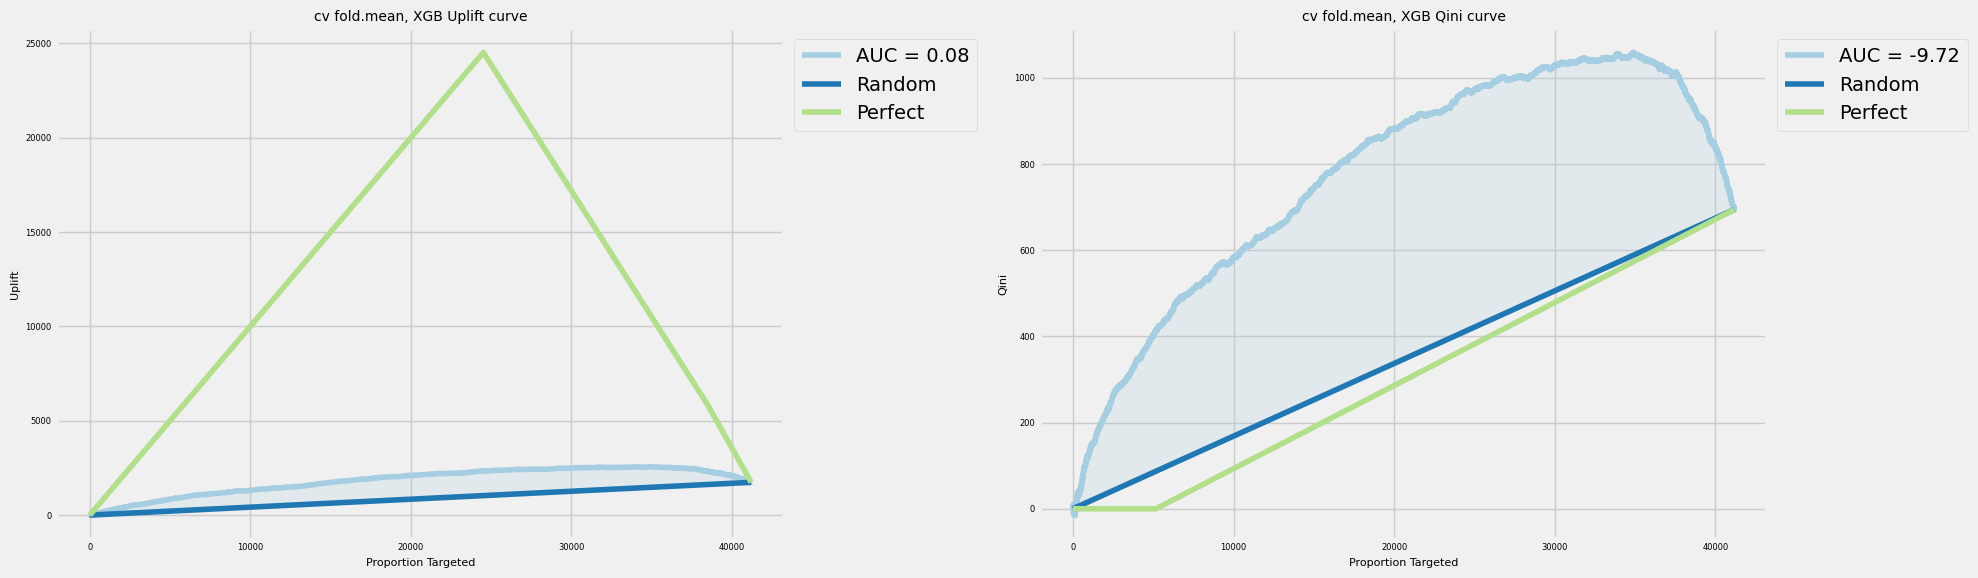

--------------------------------------------------------------------
Cross-validated T-Learner Vanila XGB Uplift Metrics (Mean):
uplift@10: 0.197
uplift@20: 0.154
uplift@30: 0.130
uplift@40: 0.116
uplift@50: 0.107
uplift@10_all: 0.170
uplift@20_all: 0.145
uplift@30_all: 0.122
uplift@40_all: 0.114
uplift@50_all: 0.103
AUUC: 0.081
qini: -10.835




--------------------------------------------------------------------
Running model: CatBoost
uplift at top 10% by group: 0.313, and overall 0.246
uplift at top 20% by group: 0.166, and overall 0.157
uplift at top 30% by group: 0.165, and overall 0.158
uplift at top 40% by group: 0.149, and overall 0.142
uplift at top 50% by group: 0.119, and overall 0.122
AUUC: 0.069
qini: -5.095
------------------------------------------------
uplift at top 10% by group: 0.201, and overall 0.238
uplift at top 20% by group: 0.120, and overall 0.107
uplift at top 30% by group: 0.118, and overall 0.097
uplift at top 40% by group: 0.116, and overall 0.129
uplift 

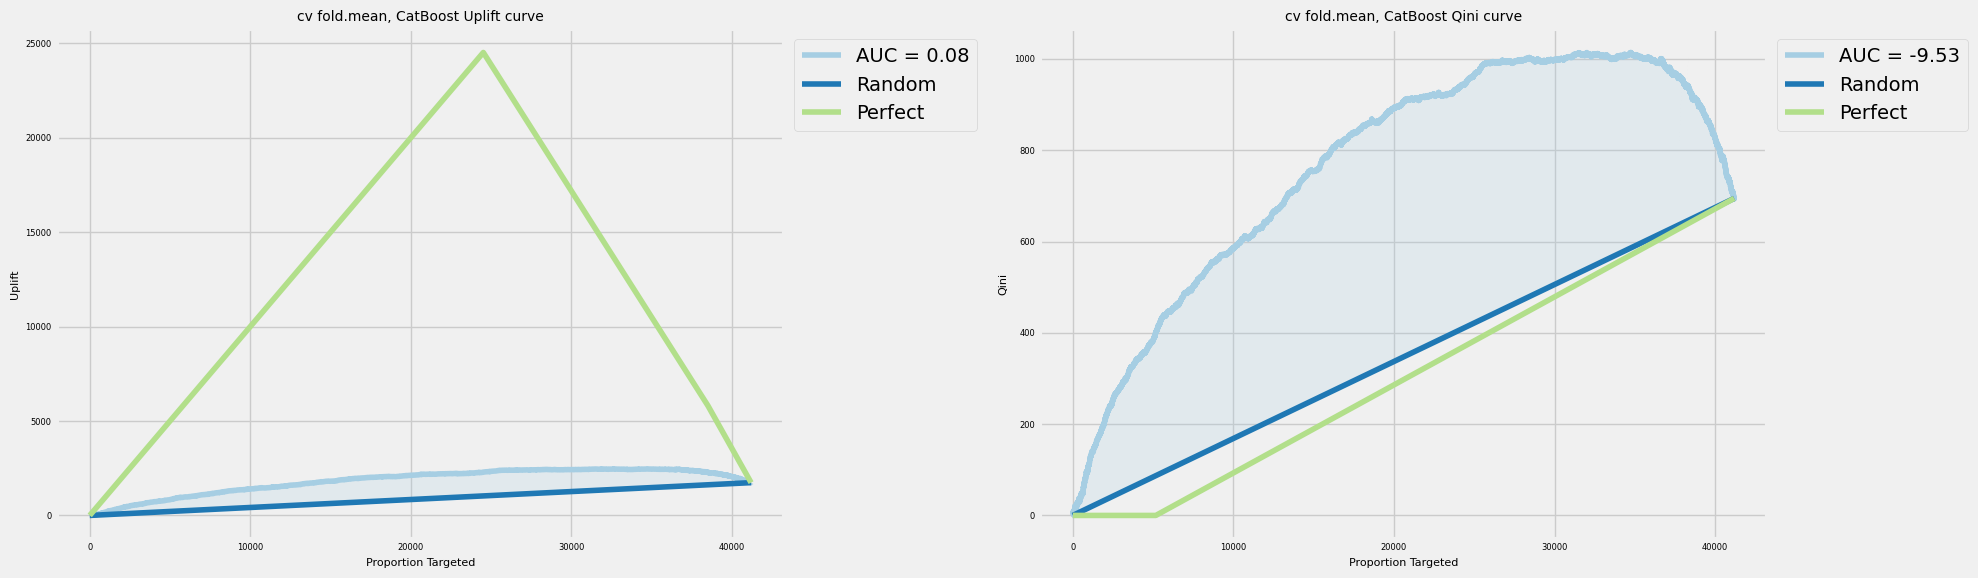

--------------------------------------------------------------------
Cross-validated T-Learner Vanila CatBoost Uplift Metrics (Mean):
uplift@10: 0.193
uplift@20: 0.158
uplift@30: 0.135
uplift@40: 0.119
uplift@50: 0.107
uplift@10_all: 0.177
uplift@20_all: 0.151
uplift@30_all: 0.129
uplift@40_all: 0.117
uplift@50_all: 0.103
AUUC: 0.082
qini: -11.369




--------------------------------------------------------------------
Running model: SVM
uplift at top 10% by group: 0.190, and overall -0.086
uplift at top 20% by group: 0.196, and overall -0.086
uplift at top 30% by group: 0.151, and overall -0.069
uplift at top 40% by group: 0.133, and overall 0.192
uplift at top 50% by group: 0.101, and overall 0.374
AUUC: 0.165
qini: 2.906
------------------------------------------------
uplift at top 10% by group: 0.211, and overall 0.173
uplift at top 20% by group: 0.196, and overall 0.331
uplift at top 30% by group: 0.124, and overall 0.334
uplift at top 40% by group: 0.088, and overall 0.224
uplif

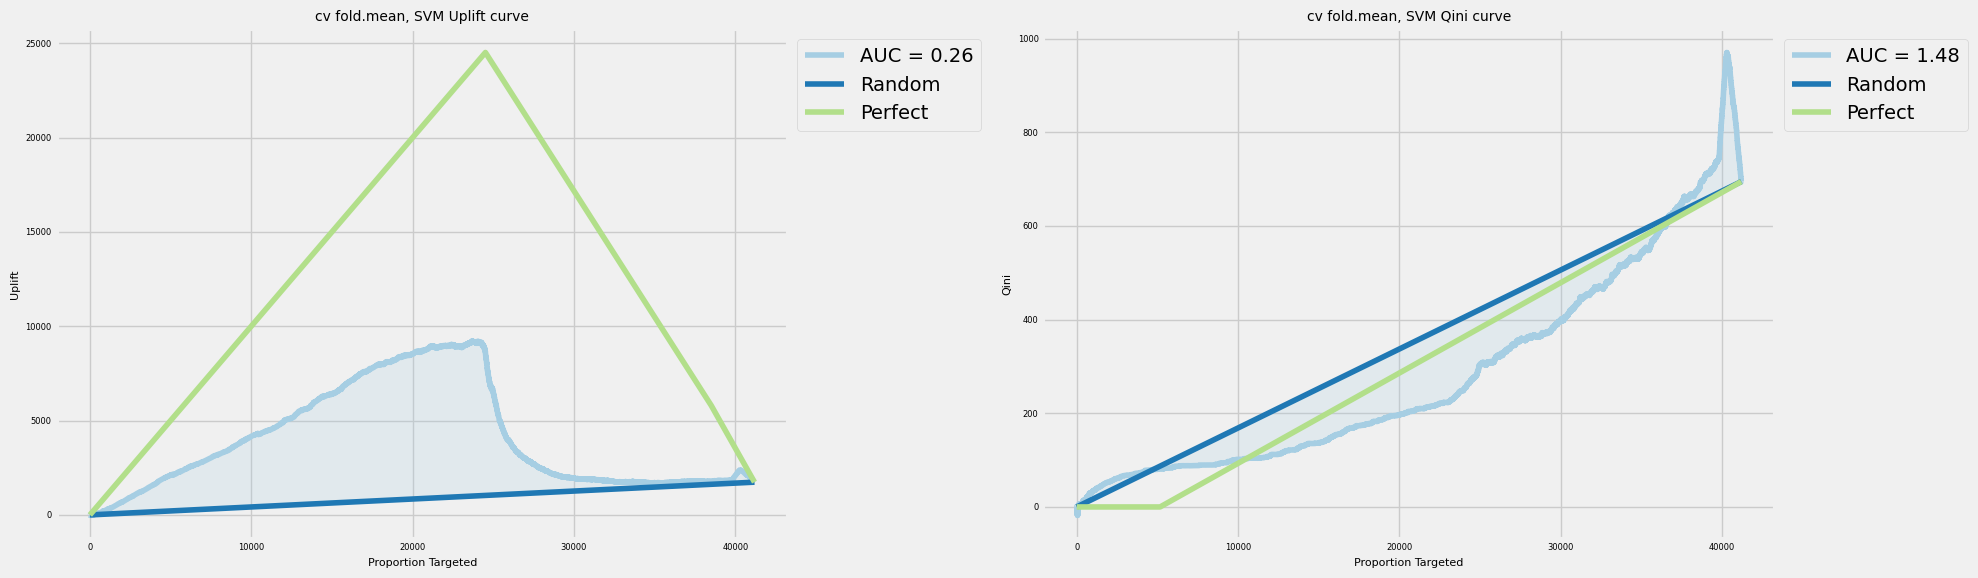

--------------------------------------------------------------------
Cross-validated T-Learner Vanila SVM Uplift Metrics (Mean):
uplift@10: 0.193
uplift@20: 0.145
uplift@30: 0.118
uplift@40: 0.101
uplift@50: 0.089
uplift@10_all: nan
uplift@20_all: 0.418
uplift@30_all: 0.444
uplift@40_all: 0.449
uplift@50_all: 0.450
AUUC: 0.293
qini: -1.072


In [34]:
results_t_vanila = run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=50)
results_df = pd.concat([results_df, results_t_vanila])

<h2>T-Learner - ddr_control</h2>

The DDR control T-Learner integrates Direct Decision Rules to adjust for confounders and refine the treatment effect estimates. It aims to improve the rebustness and reducing bias in causal interference

In [35]:
def run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=10):
    results = []
    
    for model_name, model in models.items():
        treatment_model = type(model)(**model.get_params()) #create separate instances of the same model
        control_model = type(model)(**model.get_params())
        sm = TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model, method='ddr_control')
        print("\n")
        print("\n")
        print("--------------------------------------------------------------------")
        print(f'Running model: {model_name}')
        mean_metrics, std_metrics = cross_validate_uplift_tlearner(sm, X, y, treatment, cv=cv, model_name=model_name)

        print("--------------------------------------------------------------------")
        print(f"Cross-validated T-Learner DDR control {model_name} Uplift Metrics (Mean):")
        for key, value in mean_metrics.items():
            print(f"{key}: {value:.3f}")
        
        mean_metrics['model_name'] = "t_learner_ddr_" + model_name
        results.append(mean_metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('model_name')
    
    return df





--------------------------------------------------------------------
Running model: Logit
uplift at top 10% by group: 0.199, and overall 0.181
uplift at top 20% by group: 0.127, and overall 0.129
uplift at top 30% by group: 0.117, and overall 0.119
uplift at top 40% by group: 0.109, and overall 0.108
uplift at top 50% by group: 0.102, and overall 0.103
AUUC: 0.053
qini: -3.672
------------------------------------------------
uplift at top 10% by group: 0.242, and overall 0.231
uplift at top 20% by group: 0.172, and overall 0.172
uplift at top 30% by group: 0.121, and overall 0.127
uplift at top 40% by group: 0.103, and overall 0.100
uplift at top 50% by group: 0.088, and overall 0.095
AUUC: 0.086
qini: -14.544
------------------------------------------------
uplift at top 10% by group: 0.212, and overall 0.192
uplift at top 20% by group: 0.118, and overall 0.118
uplift at top 30% by group: 0.113, and overall 0.123
uplift at top 40% by group: 0.104, and overall 0.109
uplift at top 5

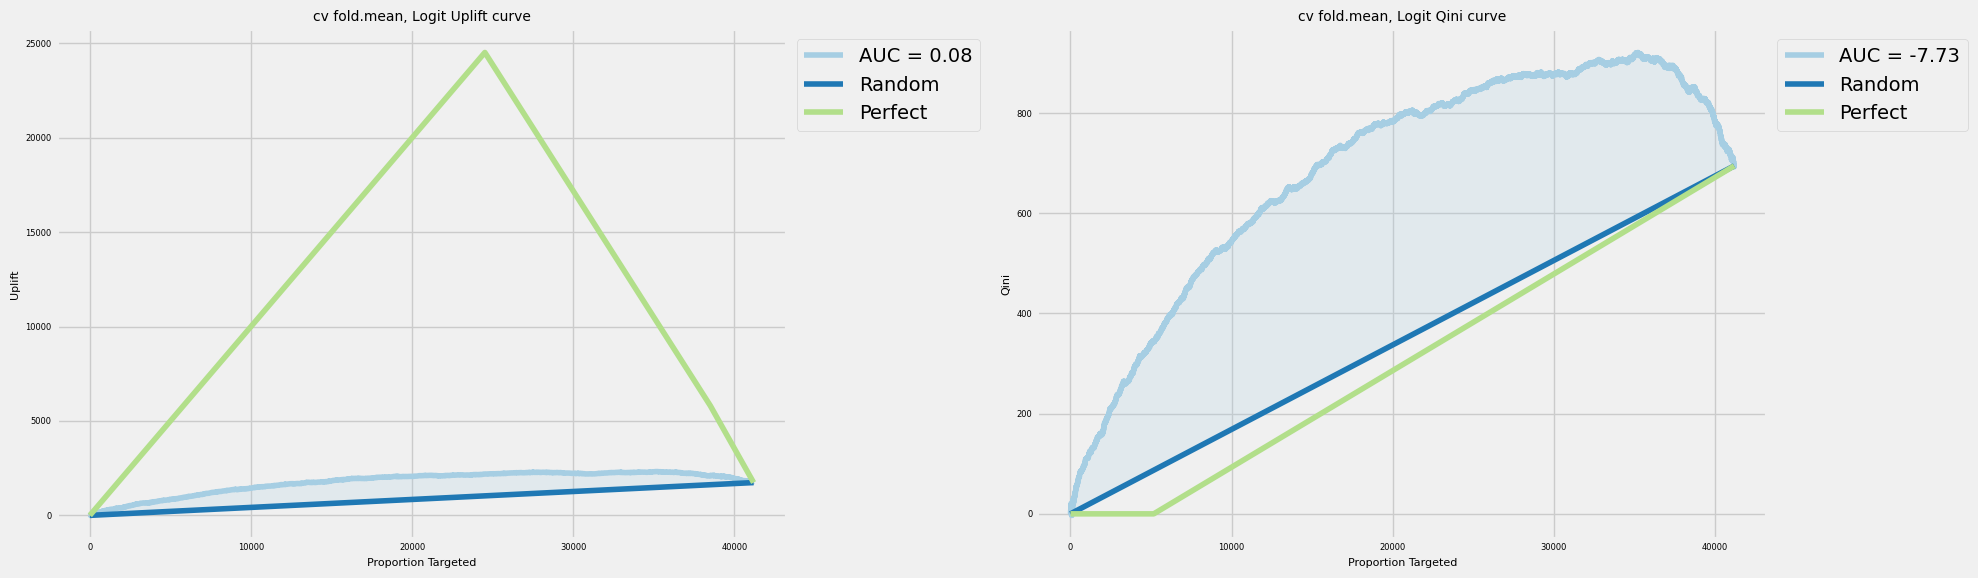

--------------------------------------------------------------------
Cross-validated T-Learner DDR control Logit Uplift Metrics (Mean):
uplift@10: 0.181
uplift@20: 0.153
uplift@30: 0.129
uplift@40: 0.113
uplift@50: 0.097
uplift@10_all: 0.180
uplift@20_all: 0.157
uplift@30_all: 0.133
uplift@40_all: 0.119
uplift@50_all: 0.102
AUUC: 0.076
qini: -7.042




--------------------------------------------------------------------
Running model: XGB
uplift at top 10% by group: 0.218, and overall 0.193
uplift at top 20% by group: 0.175, and overall 0.150
uplift at top 30% by group: 0.121, and overall 0.109
uplift at top 40% by group: 0.126, and overall 0.110
uplift at top 50% by group: 0.110, and overall 0.105
AUUC: 0.059
qini: -5.419
------------------------------------------------
uplift at top 10% by group: 0.084, and overall 0.052
uplift at top 20% by group: 0.118, and overall 0.124
uplift at top 30% by group: 0.117, and overall 0.113
uplift at top 40% by group: 0.088, and overall 0.083
uplift

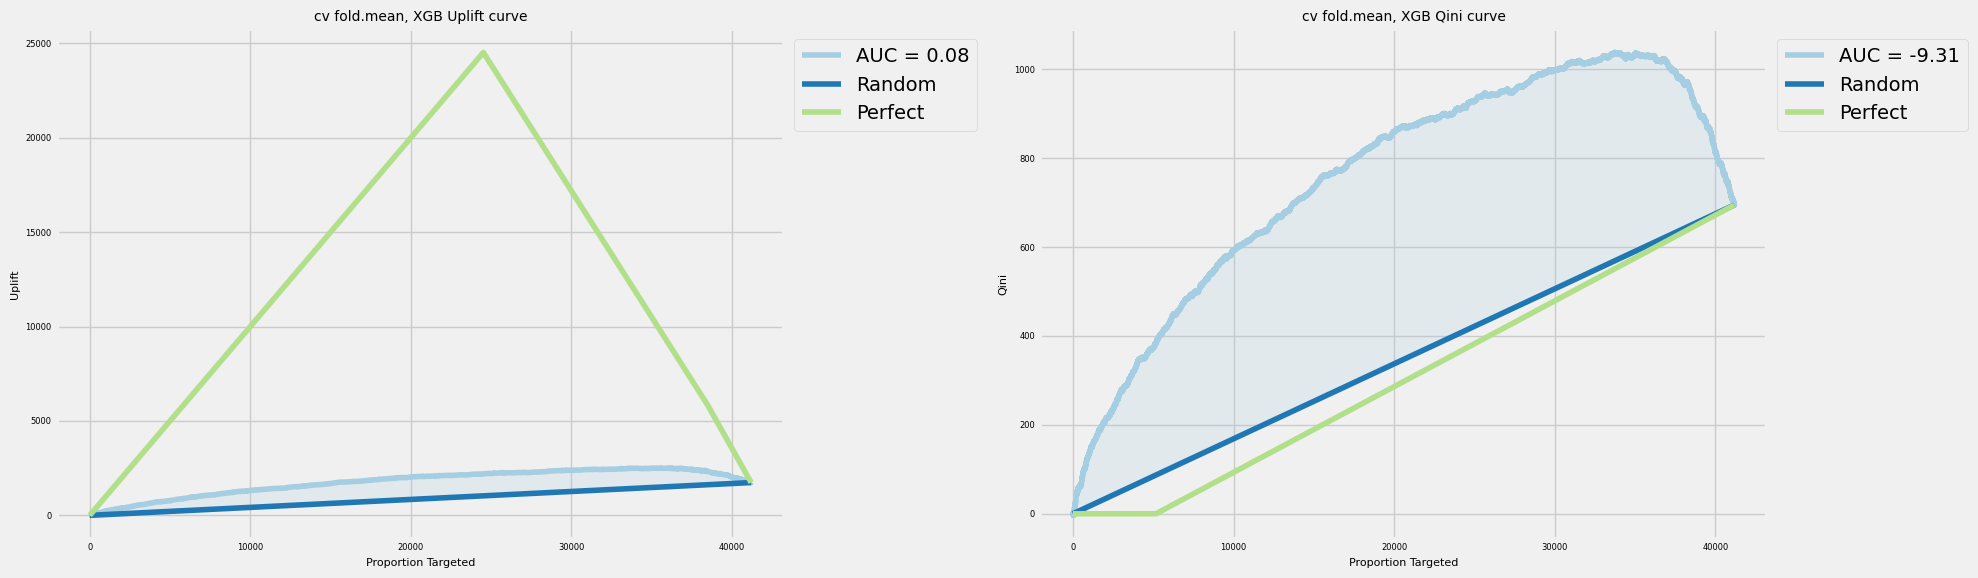

--------------------------------------------------------------------
Cross-validated T-Learner DDR control XGB Uplift Metrics (Mean):
uplift@10: 0.185
uplift@20: 0.147
uplift@30: 0.128
uplift@40: 0.115
uplift@50: 0.102
uplift@10_all: 0.164
uplift@20_all: 0.140
uplift@30_all: 0.119
uplift@40_all: 0.108
uplift@50_all: 0.099
AUUC: 0.076
qini: -8.309




--------------------------------------------------------------------
Running model: CatBoost
uplift at top 10% by group: 0.242, and overall 0.191
uplift at top 20% by group: 0.145, and overall 0.122
uplift at top 30% by group: 0.133, and overall 0.130
uplift at top 40% by group: 0.129, and overall 0.127
uplift at top 50% by group: 0.131, and overall 0.136
AUUC: 0.078
qini: -6.637
------------------------------------------------
uplift at top 10% by group: 0.108, and overall 0.088
uplift at top 20% by group: 0.114, and overall 0.117
uplift at top 30% by group: 0.121, and overall 0.138
uplift at top 40% by group: 0.095, and overall 0.102
upl

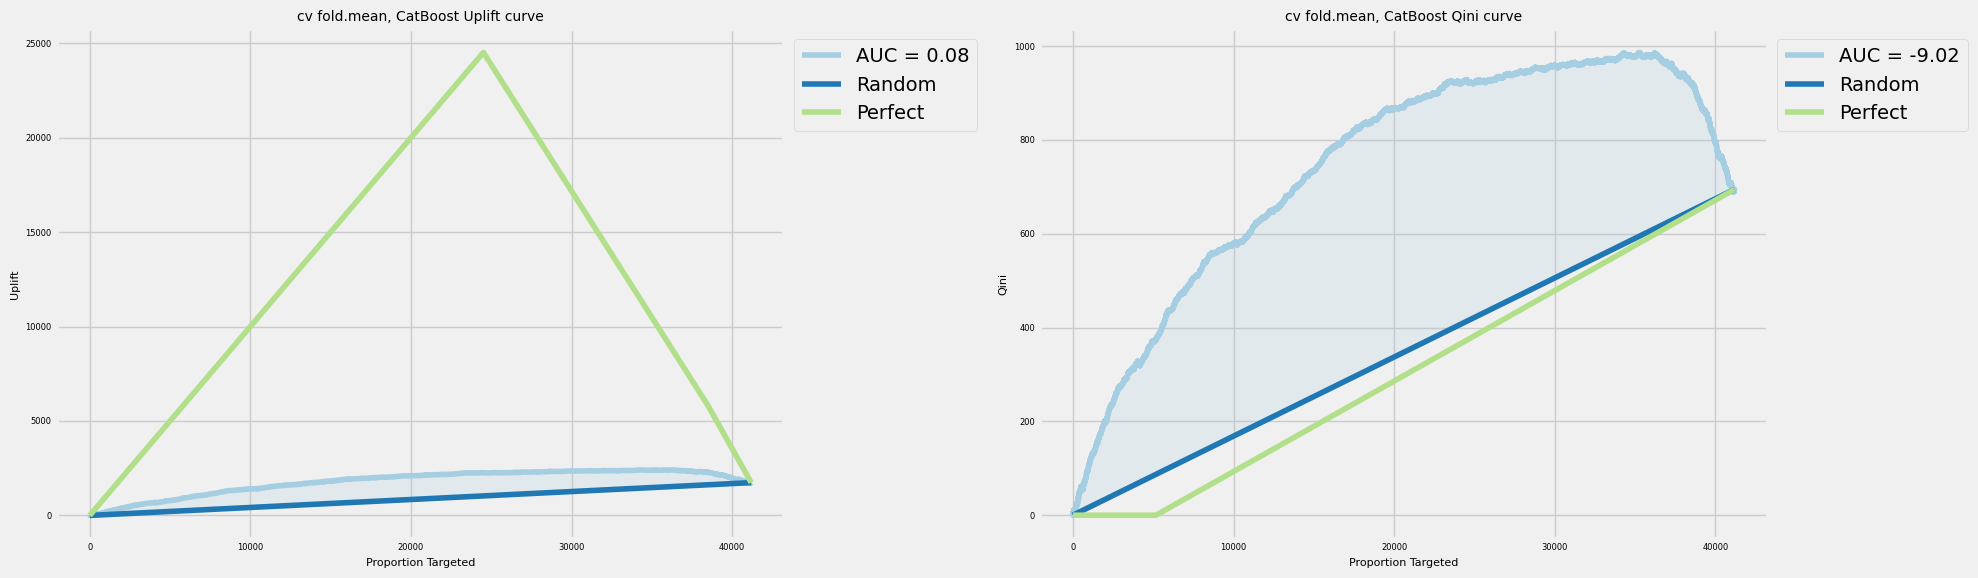

--------------------------------------------------------------------
Cross-validated T-Learner DDR control CatBoost Uplift Metrics (Mean):
uplift@10: 0.190
uplift@20: 0.158
uplift@30: 0.132
uplift@40: 0.117
uplift@50: 0.106
uplift@10_all: 0.164
uplift@20_all: 0.149
uplift@30_all: 0.133
uplift@40_all: 0.117
uplift@50_all: 0.102
AUUC: 0.078
qini: -8.482




--------------------------------------------------------------------
Running model: SVM
uplift at top 10% by group: 0.211, and overall 0.167
uplift at top 20% by group: 0.142, and overall 0.169
uplift at top 30% by group: 0.139, and overall 0.131
uplift at top 40% by group: 0.133, and overall 0.312
uplift at top 50% by group: 0.104, and overall 0.333
AUUC: 0.188
qini: 2.562
------------------------------------------------
uplift at top 10% by group: 0.175, and overall 0.122
uplift at top 20% by group: 0.118, and overall 0.045
uplift at top 30% by group: 0.078, and overall 0.038
uplift at top 40% by group: 0.088, and overall 0.164
upli

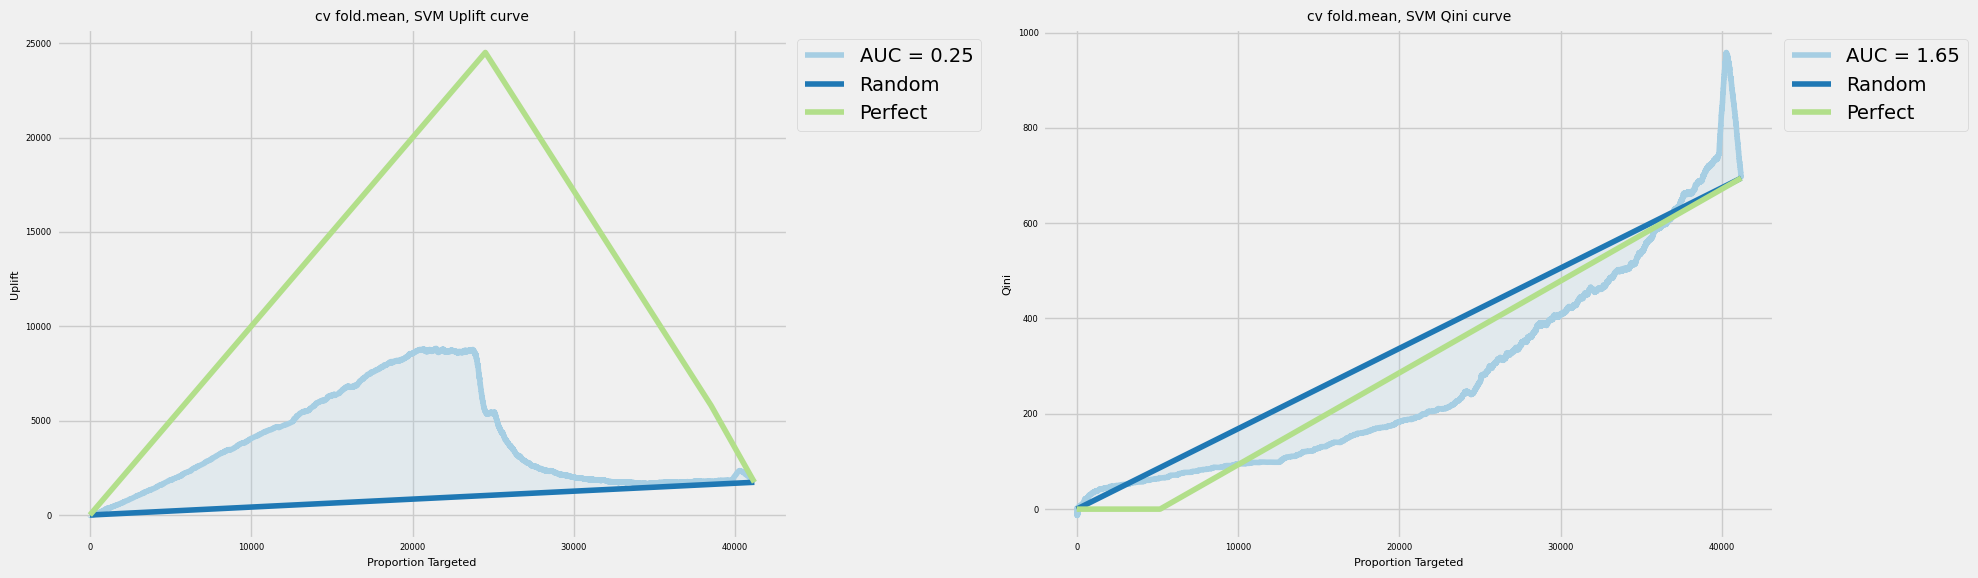

--------------------------------------------------------------------
Cross-validated T-Learner DDR control SVM Uplift Metrics (Mean):
uplift@10: 0.191
uplift@20: 0.144
uplift@30: 0.118
uplift@40: 0.102
uplift@50: 0.091
uplift@10_all: 0.415
uplift@20_all: 0.408
uplift@30_all: 0.423
uplift@40_all: 0.434
uplift@50_all: 0.449
AUUC: 0.289
qini: 0.423


In [36]:
results_t_ddr = run_tlearner_models_and_get_metrics(models, X, y, treatment, cv=30)
results_df = pd.concat([results_df, results_t_ddr])

<h2>Results</h2>

In [73]:
results_df.head(12)

,uplift@10,uplift@20,uplift@30,uplift@40,uplift@50,uplift@10_all,uplift@20_all,uplift@30_all,uplift@40_all,uplift@50_all,AUUC,qini
model_name,,,,,,,,,,,,
s_learner_Logit,-0.053348,0.003357,0.025932,0.042457,0.052637,-0.072850,-0.040372,-0.029653,-0.013717,-0.010609,-0.062547,8.815786
s_learner_XGB,0.046233,0.064375,0.068834,0.068757,0.066929,-0.060075,0.018510,0.046835,0.059114,0.061284,0.017437,-1.496476
s_learner_CatBoost,0.089399,0.104750,0.094119,0.088745,0.087392,0.042736,0.079164,0.078196,0.081632,0.081961,0.045650,-6.206721
s_learner_SVM,0.070700,0.055707,0.054633,0.052570,0.049517,0.208749,0.120935,0.086600,0.064211,0.056803,0.028480,-2.163334
t_learner_vanila_Logit,0.181407,0.151248,0.128539,0.112872,0.099416,0.182950,0.156726,0.135184,0.118279,0.103524,0.076416,-8.303712
t_learner_vanila_XGB,0.196810,0.153874,0.129868,0.116003,0.106977,0.169928,0.145136,0.121628,0.113523,0.103020,0.081029,-10.834501
t_learner_vanila_CatBoost,0.193408,0.157934,0.134870,0.118835,0.106984,0.176858,0.150587,0.129474,0.117337,0.103427,0.081505,-11.368644
t_learner_vanila_SVM,0.193382,0.145010,0.117595,0.100567,0.089101,NaN,0.417916,0.444376,0.449156,0.449851,0.293399,-1.072407
t_learner_ddr_Logit,0.180912,0.153255,0.128932,0.112736,0.097091,0.180333,0.156998,0.133481,0.118632,0.101776,0.076036,-7.041623


From the results dataframe we can see that the only model with all positive metrics is the `T-Learner SVM model with DDR control` (last model in results_df). Additionaly the SVM model is the only one that has an Uplift curve in a shape similar to the perfect one. The cross validation of the results ensures us, that the model would probably behave and classify new data with similar accuracy to the data it was trained on. We can interpret its results as:

<b>1. Uplift at 30%</b> - The expected subscription rate for the deposit product within the top 30% of the population, when considering each treatment group separately, is higher by `0.118` compared to the control group. The treatment group performs `0.118` better compared to the control group within the top 30%

<b>2. Uplift at 30% overall</b> - The expected subscription rate for the deposit product within the top 30% of the entire population, considering both treatment and control groups toghether, is higher by `0.423` compared to the control group. This value indicates a substantial difference in conversion rates between the treatment and control groups. It suggests that the treatment is highly effective in this segment, and it identifies the most responsive customers well, leading to a higher conversion rate in the treatment group


<b>3. AUUC score</b> - The value of `0.29` indicates that the cumulative uplift across the entire population is moderate. It suggests that the treatment is effective in improving the conversion rate, but its overall impact is not very high.

<b>4. QINI score</b> - qini coefficient of `0.423` indicates a strong cumulative uplift, particularly in the top segments of the population. This suggests that the treatment is effective in persuading the most responsive customers to subscribe the term deposit product. The uplidt model is effectively identifying and targeting the most responsvie customers, leading to a significant improvement in subscription rates.

cross validated Uplift and QINI curves (SVM radial kernel) can be seen on the graph below

<img src="static/SVM_final.png">